# 01 - Airbnb Pricing EDA: Cross‑City Price Analysis (PySpark)

This notebook performs end‑to‑end exploratory analysis of consolidated Airbnb pricing data across major European cities. It performs scalable data ingestion with a Spark pipeline and provides initial exploratory insights: price distributions by city and day type, correlation analysis with key features, price decile segmentation, seasonal/temporal patterns, price elasticity visualizations, and summary statistics exported as artifacts.

Key highlights:
- Scalable ingestion & preprocessing using PySpark (consolidated parquet)
- EDA and robust aggregations via Spark SQL, with safe Pandas sampling for plotting
- Visualizations with Matplotlib / Seaborn (price distributions, heatmaps, deciles)
- Feature correlation and segmentation to inform pricing strategy
- Reproducible outputs saved to outputs/ (PNGs, CSVs) suitable for reporting or further modeling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Hadoop setup + imports (must run before ANY pyspark code)
import sys, os
from pathlib import Path
import urllib.request
import shutil

# locate project_root (stop at parent that contains src)
project_root = Path.cwd()
for p in [project_root] + list(project_root.parents):
    if (p / "src").exists():
        project_root = p
        break
if not (project_root / "src").exists():
    raise FileNotFoundError("Could not find 'src' directory.")

# ensure hadoop/bin present
hadoop_home = project_root / "hadoop"
bin_dir = hadoop_home / "bin"
bin_dir.mkdir(parents=True, exist_ok=True)

# check winutils.exe presence
winutils = bin_dir / "winutils.exe"
if not winutils.exists():
    url = "https://github.com/kontext-tech/winutils/raw/master/hadoop-3.3.1/bin/winutils.exe"
    print(f"winutils.exe not found at hadoop/bin. Downloading from {url} ...")
    try:
        with urllib.request.urlopen(url) as resp, open(winutils, "wb") as out:
            shutil.copyfileobj(resp, out)
        print(f"Downloaded winutils.exe -> hadoop/bin")
    except Exception as e:
        print(f"Failed to download winutils.exe: {e}")
else:
    print(f"winutils.exe already exists: hadoop/bin")
# check haddop.dll presence
hadoop_dll = bin_dir / "hadoop.dll"
if not hadoop_dll.exists():
    url = "https://github.com/kontext-tech/winutils/raw/master/hadoop-3.3.1/bin/hadoop.dll"
    print(f"hadoop.dll not found at hadoop/bin. Downloading from {url} ...")
    try:
        with urllib.request.urlopen(url) as resp, open(hadoop_dll, "wb") as out:
            shutil.copyfileobj(resp, out)
        print(f"Downloaded hadoop.dll -> hadoop/bin")
    except Exception as e:
        print(f"Failed to download hadoop.dll: {e}")


os.environ["HADOOP_HOME"] = str(hadoop_home)
os.environ["hadoop.home.dir"] = str(hadoop_home)

sys.path.insert(0, str(project_root))

# IMPORTANT: make sure hadoop\bin is on PATH so the JVM can load hadoop.dll
os.environ["PATH"] = str(bin_dir) + os.pathsep + os.environ.get("PATH", "")

# NOW safe to import pipeline (it will handle HADOOP_HOME internally)
from src.data_processing.pyspark_ingestion_pipeline import AirbnbSparkPipeline
from pyspark.sql.functions import col, month, desc, avg, min, max, count
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Ready for Spark operations.")

winutils.exe already exists: hadoop/bin
Ready for Spark operations.


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("diag").getOrCreate()
print("Spark version:", spark.version)
print("Hadoop version:", spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion())

Spark version: 3.5.0
Hadoop version: 3.3.4


In [4]:
print("winutils exists:", os.path.exists(rf"{os.environ.get('HADOOP_HOME')}\bin\winutils.exe"))
print("hadoop.dll exists:", os.path.exists(rf"{os.environ.get('HADOOP_HOME')}\bin\hadoop.dll"))

from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("test") \
    .config("spark.hadoop.io.file.buffer.size", "8000") \
    .config("spark.sql.files.ignoreMissingFiles", "true") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

# TEST WRITE
df = spark.range(5)
df.write.mode("overwrite").parquet("test.parquet")
print("PARQUET WRITE SUCCESS!")


winutils exists: True
hadoop.dll exists: True
PARQUET WRITE SUCCESS!


In [5]:
# Load data and run PySpark ingestion pipeline
print("=" * 60)
print("Starting pipeline initialization...")
print("=" * 60)

data_dir = project_root / "data"
if not data_dir.exists():
    alt_data_dir = project_root.parent / "data"
    if alt_data_dir.exists():
        data_dir = alt_data_dir
    else:
        raise FileNotFoundError(f"No data/ folder found")

print(f"Data directory exists: {data_dir.exists()}")

pipeline = AirbnbSparkPipeline(data_path=str(data_dir / 'airbnb_listings.csv'))
df = pipeline.run_pipeline()

output_path = data_dir / 'processed' / 'consolidated.parquet'
print(f"\nPipeline completed successfully!")
print(f"Saved parquet")
print(f"DataFrame rows: {df.count():,}")

Starting pipeline initialization...
Data directory exists: True

Pipeline completed successfully!
Saved parquet
DataFrame rows: 310,242


In [6]:
# Basic PySpark EDA (schema, counts, samples)
print("Schema:")
df.printSchema()

total = df.count()
print(f"Total records: {total:,}")

print("Sample rows:")
df.select("city", "listing_price", "person_capacity", "guest_satisfaction_overall", "weekend", "season", "occupancy_rate").show(10, truncate=False)

Schema:
root
 |-- listing_price: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- person_capacity: double (nullable = true)
 |-- host_is_superhost: integer (nullable = true)
 |-- multi: integer (nullable = true)
 |-- biz: integer (nullable = true)
 |-- cleanliness_rating: double (nullable = true)
 |-- guest_satisfaction_overall: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- city_center_dist: double (nullable = true)
 |-- metro_dist: double (nullable = true)
 |-- city: string (nullable = true)
 |-- listing_id: integer (nullable = true)
 |-- season: string (nullable = true)
 |-- weekend: integer (nullable = true)
 |-- days_in_period: double (nullable = true)
 |-- days_booked: double (nullable = true)
 |-- occupancy_rate: double (nullable = true)

Total records: 310,242
Sample rows:
+---------+------------------+---------------+--------------------------+-------+--------+------------------+
|city     |listing_price     |person_capacity|guest_s

In [7]:
# Price Distribution Analysis (PySpark-first; collect only aggregates/samples for plotting)

from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Basic data quality checks (prettier Spark → Pandas display)
cols = [
    c for c in [
        "listing_price", "city", "weekend", "room_type",
        "person_capacity", "city_center_dist", "metro_dist", 
        "occupancy_rate", "cleanliness_rating", "guest_satisfaction_overall",
    ] if c in df.columns
]

dq_exprs = [
    (F.mean(F.col(c).isNull().cast("double")) * 100).alias(c)
    for c in cols
]

dq_pdf = df.select(*dq_exprs).toPandas().T.reset_index()
dq_pdf.columns = ["column", "null_pct"]
dq_pdf["null_pct"] = dq_pdf["null_pct"].astype(float)

fmt_dq = {"null_pct": "{:.1f}%"}

display(
    dq_pdf.style.format(fmt_dq)
                 .set_table_attributes("style='width:50%; font-family: Arial; font-size:12px;'")
                 .set_caption("Null % (selected cols; Spark → Pandas)")
)

# Robust distribution stats overall + by segments (Spark aggregations)
price_stats_overall = df.agg(
    F.count("*").alias("n"),
    F.mean("listing_price").alias("mean"),
    F.expr("percentile_approx(listing_price, 0.5)").alias("median"),
    F.stddev("listing_price").alias("std"),
    F.min("listing_price").alias("min"),
    F.max("listing_price").alias("max"),
    F.expr("percentile_approx(listing_price, 0.1)").alias("p10"),
    F.expr("percentile_approx(listing_price, 0.9)").alias("p90"),
)

# Pretty-print overall price stats
overall_pdf = price_stats_overall.toPandas()
overall_pdf["n"] = overall_pdf["n"].astype(int)

fmt_overall = {
    "n": "{:,}",
    "mean": "{:,.1f}",
    "median": "{:,.1f}",
    "std": "{:,.1f}",
    "min": "{:,.1f}",
    "max": "{:,.1f}",
    "p10": "{:,.1f}",
    "p90": "{:,.1f}",
}

display(
    overall_pdf.style.format(fmt_overall)
                     .set_table_attributes("style='width:50%; font-family: Arial; font-size:12px;'")
                     .set_caption("Overall price stats (Spark → Pandas)")
)

# Segment-level summary table (recruiter-friendly)
segment_stats = (
    df.groupBy("city", "weekend")
      .agg(
          F.count("*").alias("n"),
          F.mean("listing_price").alias("avg_price"),
          F.expr("percentile_approx(listing_price, 0.5)").alias("median_price"),
          F.stddev("listing_price").alias("std_price"),
          F.expr("percentile_approx(listing_price, 0.1)").alias("p10"),
          F.expr("percentile_approx(listing_price, 0.9)").alias("p90"),
          F.mean("city_center_dist").alias("avg_dist"),
          F.mean("person_capacity").alias("avg_capacity"),
          F.mean("guest_satisfaction_overall").alias("avg_guest_satisfaction_overall"),
          F.min("listing_price").alias("min_price"),
          F.max("listing_price").alias("max_price"),
          F.mean("cleanliness_rating").alias("avg_cleanliness_rating"),
          F.mean("occupancy_rate").alias("avg_occupancy_rate"),
      )
      .orderBy("city", "weekend")
)

print("Price stats by city x weekend (Spark):")
segment_stats_pdf = segment_stats.limit(5000).toPandas().sort_values(["city", "weekend"])
segment_stats_pdf["n"] = segment_stats_pdf["n"].astype(int)

fmt_seg = {
    "n": "{:,}",
    "avg_price": "{:,.1f}",
    "median_price": "{:,.1f}",
    "std_price": "{:,.1f}",
    "p10": "{:,.1f}",
    "p90": "{:,.1f}",
    "avg_dist": "{:,.1f}",
    "avg_capacity": "{:,.1f}",
    "avg_guest_satisfaction_overall": "{:,.1f}",
    "min_price": "{:,.1f}",
    "max_price": "{:,.1f}",
    "avg_cleanliness_rating": "{:,.1f}",
    "avg_occupancy_rate": "{:,.1f}",
}

display(
    segment_stats_pdf.style.format(fmt_seg)
                     .set_table_attributes("style='width:90%; font-family: Arial; font-size:12px;'")
                     .set_caption("Price stats by city x weekend (Spark → Pandas)")
)

# Plotting using a bounded sample to avoid collecting full Spark DF

total_count = df.count()
sample_n = 20000
fraction = (sample_n * 1.2) / total_count  # 20% buffer for variance

plot_pdf = (
    df.select("city", "weekend", "season", "room_type", "listing_price", "cleanliness_rating", "guest_satisfaction_overall", "occupancy_rate")
      .where(F.col("listing_price").isNotNull())
      .sample(withReplacement=False, fraction=fraction, seed=42)   # oversample then cap
      .limit(sample_n)
      .toPandas()
)

# Map weekend to readable labels for plots
if "weekend" in plot_pdf.columns:
    plot_pdf["day_type"] = plot_pdf["weekend"].map({0: "weekday", 1: "weekend"}).astype(str)

# Reduce the influence of extreme outliers for boxplots (keep full stats above)
p01, p99 = df.approxQuantile("listing_price", [0.01, 0.99], 0.001)
plot_pdf_clip = plot_pdf[(plot_pdf["listing_price"] >= p01) & (plot_pdf["listing_price"] <= p99)].copy()

fig, axes = plt.subplots(3, 2, figsize=(16, 11))

# By season
sns.boxplot(data=plot_pdf_clip, x="season", y="listing_price", ax=axes[0, 0])
axes[0, 0].set_title("Price Distribution by Season (sampled; clipped p01–p99)")
axes[0, 0].set_ylabel("Price")
axes[0, 0].tick_params(axis="x", rotation=45)

# By day type (weekday vs weekend)
x_day = "day_type" if "day_type" in plot_pdf_clip.columns else "weekend"
sns.boxplot(data=plot_pdf_clip, x=x_day, y="listing_price", ax=axes[0, 1])
axes[0, 1].set_title("Price: Weekday vs Weekend (sampled; clipped p01–p99)")
axes[0, 1].set_ylabel("Price")

# By room type
sns.boxplot(data=plot_pdf_clip, x="room_type", y="listing_price", ax=axes[1, 0])
axes[1, 0].set_title("Price by Room Type (sampled; clipped p01–p99)")
axes[1, 0].set_ylabel("Price")
axes[1, 0].tick_params(axis="x", rotation=45)

# guest_satisfaction_overall vs price
sns.boxplot(data=plot_pdf, y="guest_satisfaction_overall", x="cleanliness_rating", ax=axes[1, 1])
axes[1, 1].set_title("Guest Satisfaction vs Cleanliness Rating (sampled)")
axes[1, 1].set_ylabel("Guest Satisfaction")

# Histogram (log-scale option is often useful for heavy-tailed price)
axes[2, 0].hist(plot_pdf["listing_price"], bins=60, log=True)
axes[2, 0].set_title("Price Histogram (sampled; log y-scale)")
axes[2, 0].set_xlabel("Price")
axes[2, 0].set_ylabel("Count (log scale)")

# Histogram (log-scale option is often useful for heavy-tailed price)
axes[2, 1].hist(plot_pdf["occupancy_rate"], bins=60, log=True)
axes[2, 1].set_title("Occupancy Rate Histogram (sampled; log y-scale)")
axes[2, 1].set_xlabel("Occupancy Rate")
axes[2, 1].set_ylabel("Count (log scale)")


plt.tight_layout()

# Save to a deterministic project path
output_dir = project_root / "outputs"
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / "price_distributions.png", dpi=150)
plt.show()

Price stats by city x weekend (Spark):


Analyzing 8 numeric columns
Computing correlations...
  person_capacity: 0.7449
  cleanliness_rating: 0.0657
  guest_satisfaction_overall: 0.0615
  bedrooms: 0.4800
  city_center_dist: -0.2502
  metro_dist: -0.1954
  days_in_period: -0.0750
  days_booked: 0.0783

Top 20 correlations:
                   feature    corr  abs_corr
           person_capacity  0.7449    0.7449
                  bedrooms  0.4800    0.4800
          city_center_dist -0.2502    0.2502
                metro_dist -0.1954    0.1954
               days_booked  0.0783    0.0783
            days_in_period -0.0750    0.0750
        cleanliness_rating  0.0657    0.0657
guest_satisfaction_overall  0.0615    0.0615


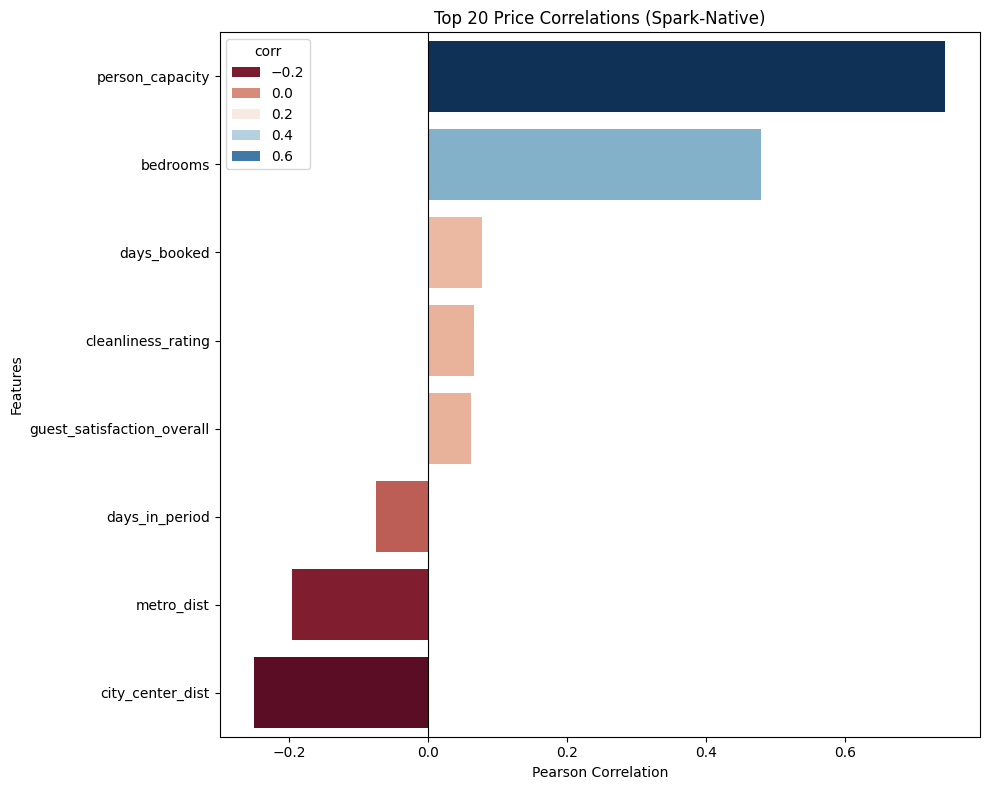

In [8]:
# Correlation Analysis
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# FORCE LOCAL MODE
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")
spark.conf.set("spark.default.parallelism", "1") 
spark.conf.set("spark.sql.adaptive.enabled", "false")

# Get numeric columns (Spark-native, no collect)
numeric_cols = [f.name for f in df.schema.fields 
                if f.dataType.simpleString().lower() in {"double", "float", "integer", "long"}
                and f.name not in {"listing_price", "occupancy_rate"}][:30]  # Limit 30 cols

print(f"Analyzing {len(numeric_cols)} numeric columns")

# SPARK-NATIVE correlations
print("Computing correlations...")
corr_dict = {}
for col in numeric_cols:
    try:
        corr_val = df.stat.corr("listing_price", col)
        corr_dict[col] = float(corr_val)
        print(f"  {col}: {corr_val:.4f}")
    except:
        corr_dict[col] = 0.0

# Pure Python sorting (tiny dict, no Spark)
corr_pdf = pd.DataFrame([
    {"feature": k, "corr": v, "abs_corr": abs(v)} 
    for k, v in corr_dict.items()
]).sort_values("abs_corr", ascending=False).head(20)

print("\nTop 20 correlations:")
print(corr_pdf.round(4).to_string(index=False))

# Plotting (tiny pandas df = safe)
plt.figure(figsize=(10, 8))
sns.barplot(data=corr_pdf.sort_values("corr", ascending=False), y="feature", x="corr", palette="RdBu", hue="corr")
plt.title("Top 20 Price Correlations (Spark-Native)")
plt.xlabel("Pearson Correlation")
plt.ylabel("Features")
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()

# Save
output_dir = Path(project_root) / "outputs"
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / "top_price_correlations.png", dpi=150, bbox_inches='tight')
plt.show()


Creating heatmap for top 8 features...


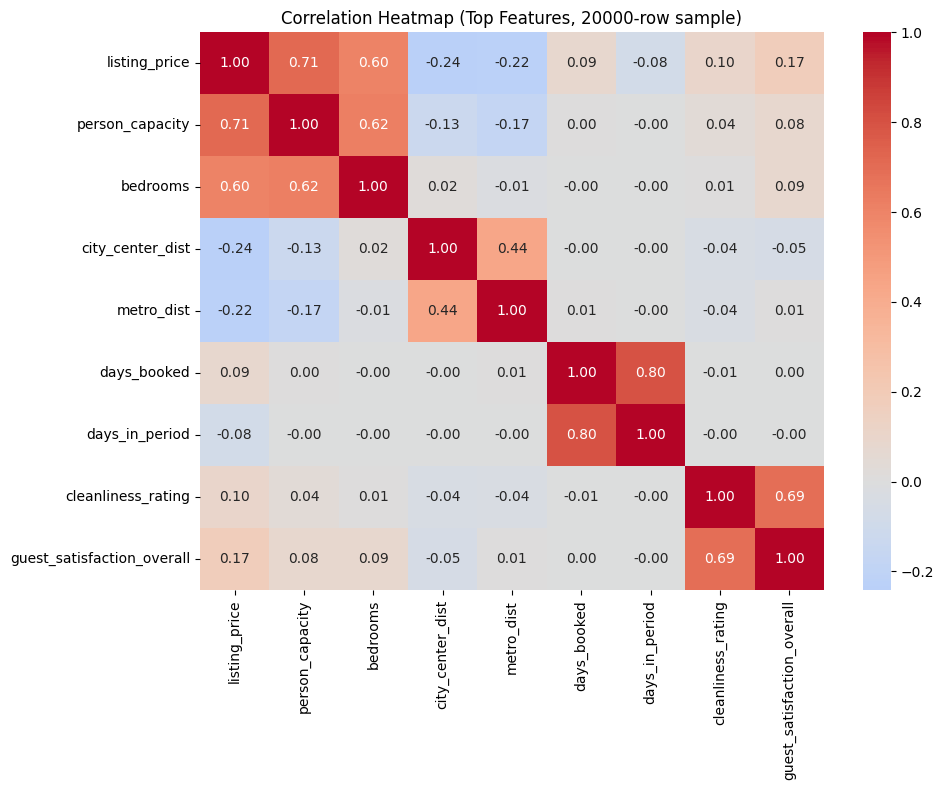

In [9]:
# Safe heatmap from top 10 features only
if len(corr_pdf) >= 10:
    top_features = corr_pdf.sort_values("abs_corr", ascending=False).head(10)["feature"].tolist()
else:
    top_features = corr_pdf["feature"].tolist()
print(f"Creating heatmap for top {len(top_features)} features...")

# Tiny sample → Pure Spark → toPandas SAFE
sample_cols = ["listing_price"] + top_features
heatmap_data = df.select(*sample_cols)\
                .where(F.col("listing_price").isNotNull())\
                .limit(20000).toPandas()

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data.corr(numeric_only=True), 
            cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Correlation Heatmap (Top Features, 20000-row sample)")
plt.tight_layout()
plt.savefig(output_dir / "correlation_heatmap_safe.png", dpi=150)
plt.show()



Processing city: amsterdam ...



Processing city: athens ...


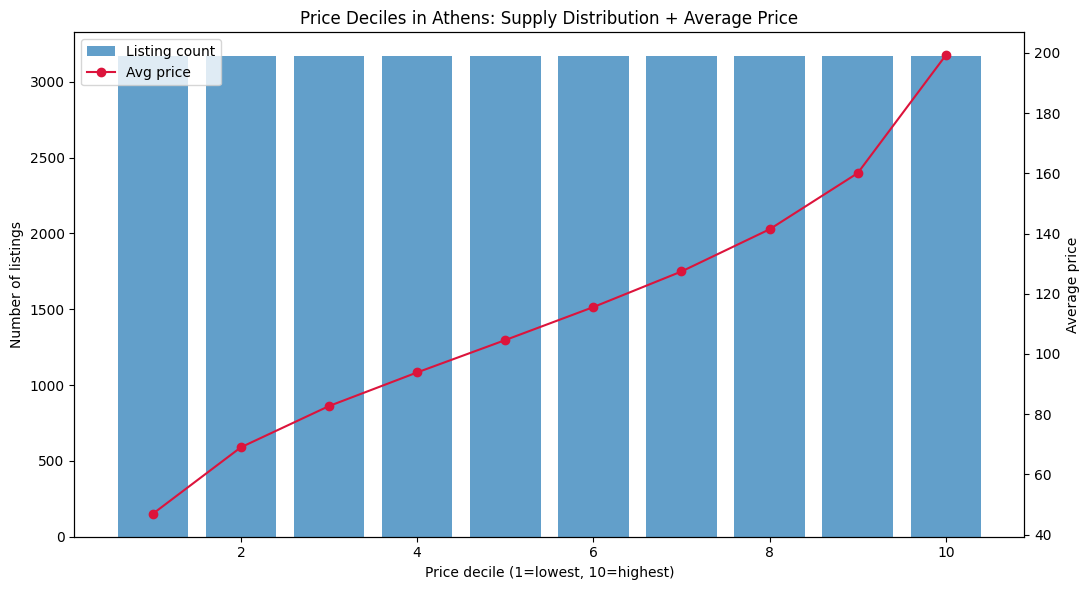


Processing city: barcelona ...



Processing city: berlin ...



Processing city: budapest ...


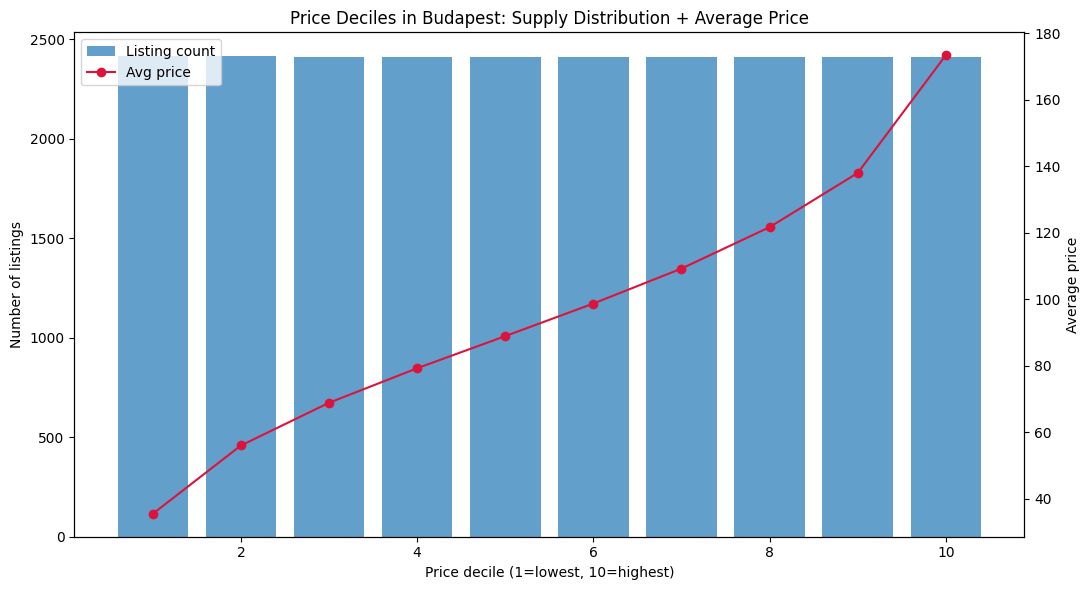


Processing city: lisbon ...


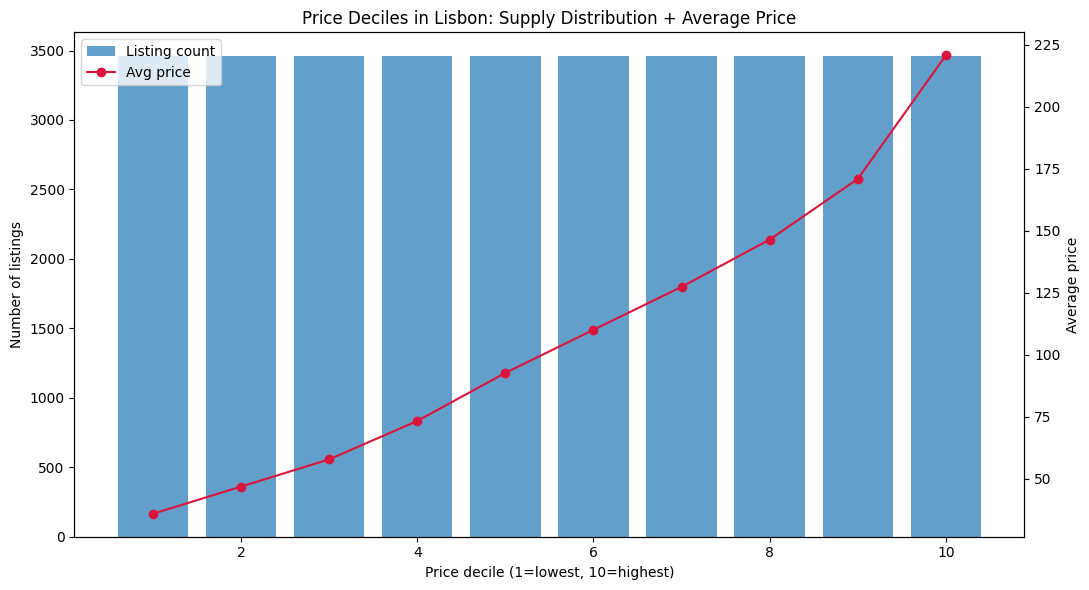


Processing city: london ...


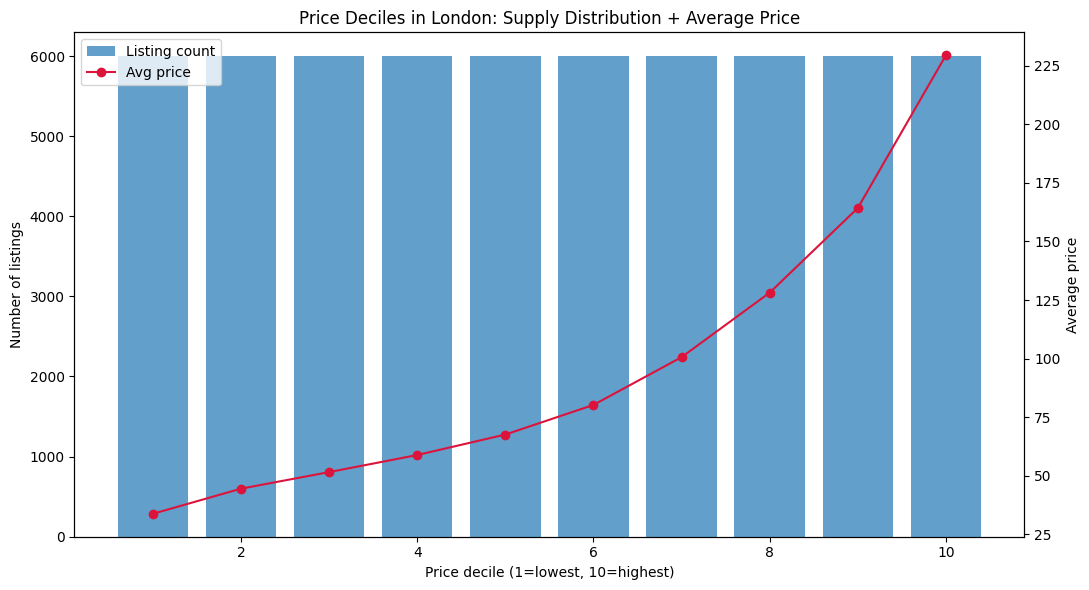


Processing city: paris ...


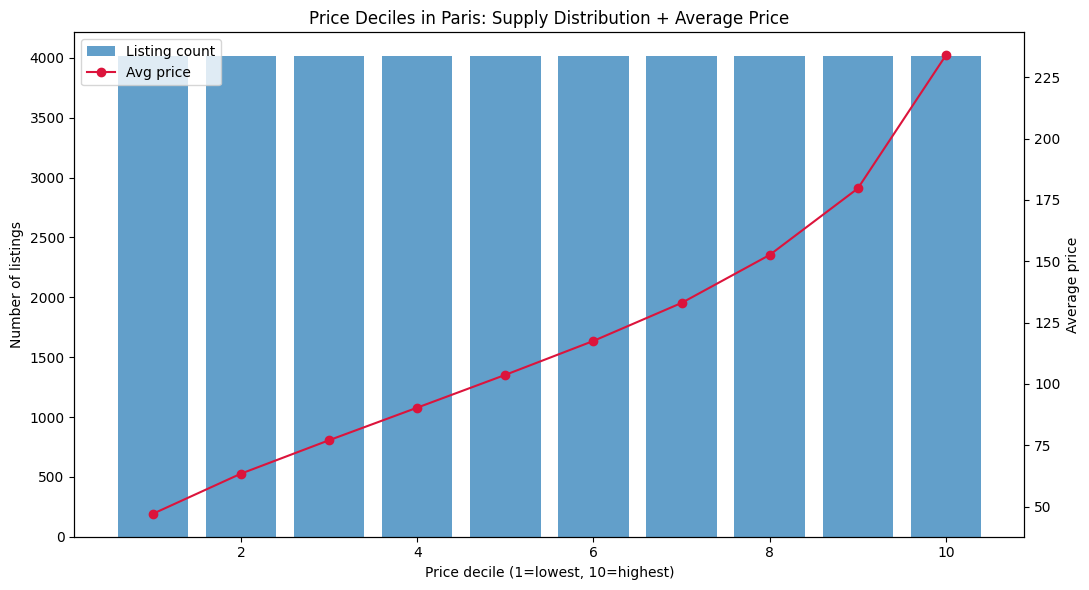


Processing city: rome ...


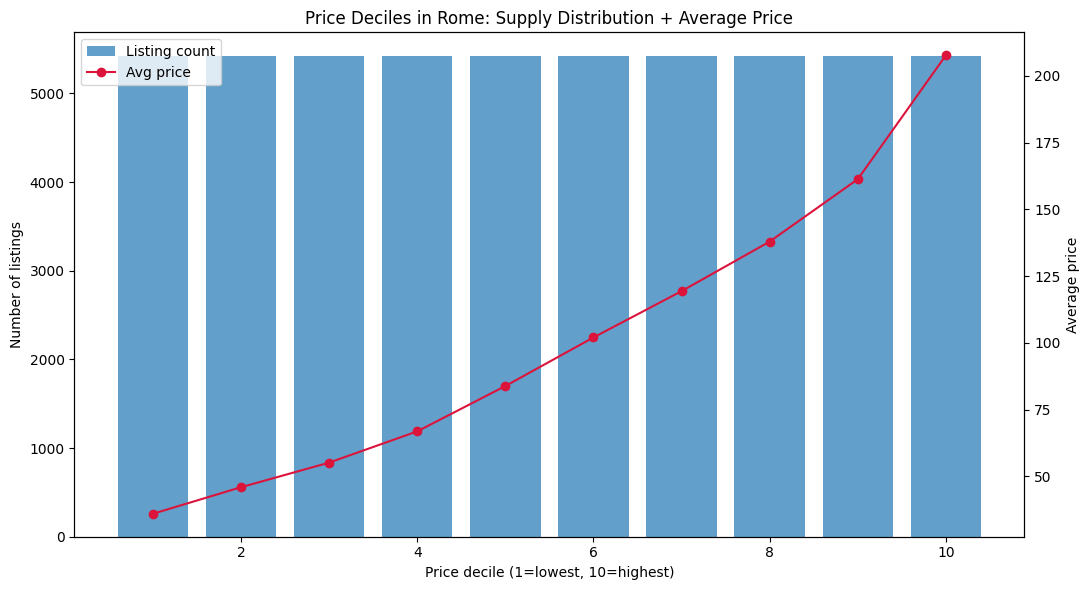


Processing city: vienna ...


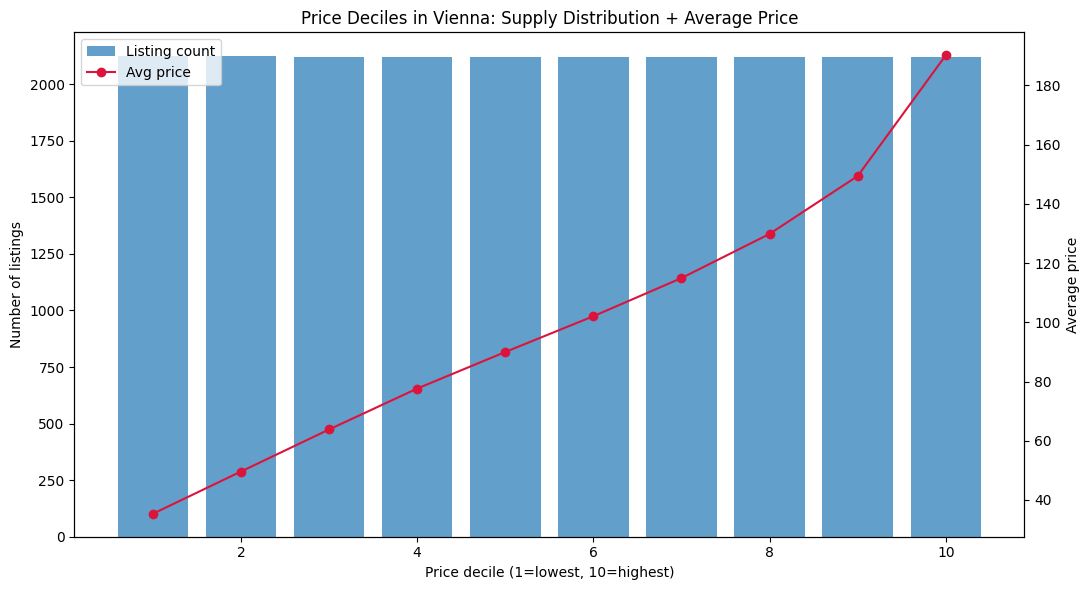

In [10]:
# Price Segmentation and Analysis (Spark deciles via ntile)

from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Plot: Supply distribution + avg price by decile for each city
city_list = ['amsterdam','athens','barcelona','berlin','budapest','lisbon','london','paris','rome','vienna']
for city in city_list:
    print(f"\nProcessing city: {city} ...")
    df_city = df.where((F.col("listing_price").isNotNull()) & (F.col("city") == city))
    
    # Create price deciles using Spark window
    w = Window.orderBy(F.col("listing_price").asc())
    df_deciles_city = df_city.withColumn("price_decile", F.ntile(10).over(w))

    price_deciles_spark_city = (
        df_deciles_city.groupBy("price_decile")
          .agg(
              F.count("*").alias("listing_count"),
              F.mean("listing_price").alias("avg_price"),
              F.expr("percentile_approx(listing_price, 0.5)").alias("median_price"),
              F.mean("guest_satisfaction_overall").alias("avg_satisfaction"),
              F.mean("cleanliness_rating").alias("avg_cleanliness"),
              F.mean("person_capacity").alias("avg_capacity"),
              F.mean("city_center_dist").alias("avg_dist"),
              F.mean("occupancy_rate").alias("avg_occupancy_rate"),
          )
          .orderBy("price_decile")
    )

    # Pretty-print Spark aggregate via a styled Pandas DataFrame
    price_deciles_pdf_city = price_deciles_spark_city.limit(5000).toPandas().sort_values("price_decile")
    price_deciles_pdf_city["listing_count"] = price_deciles_pdf_city["listing_count"].astype(int)

    # Formatting dict for deciles table (was missing 'fmt' variable)
    fmt_deciles = {
        "listing_count": "{:,}",
        "avg_price": "{:,.0f}",
        "median_price": "{:,.0f}",
        "avg_satisfaction": "{:.1f}",
        "avg_cleanliness": "{:.1f}",
        "avg_capacity": "{:.1f}",
        "avg_dist": "{:.1f}",
        "avg_occupancy_rate": "{:.2f}",
    }

    display(
        price_deciles_pdf_city.style.format(fmt_deciles)
                           .set_table_attributes("style='width:80%; font-family: Arial; font-size:12px;'")
                           .set_caption(f"Price deciles summary for {city.capitalize()} (Spark → Pandas)")
    )

    # Plot Supply distribution + avg price by decile
    fig, ax1 = plt.subplots(figsize=(11, 6))
    ax2 = ax1.twinx()

    ax1.bar(price_deciles_pdf_city["price_decile"], price_deciles_pdf_city["listing_count"], alpha=0.7, label="Listing count")
    ax2.plot(price_deciles_pdf_city["price_decile"], price_deciles_pdf_city["avg_price"], color="crimson", marker="o", label="Avg price")

    ax1.set_xlabel("Price decile (1=lowest, 10=highest)")
    ax1.set_ylabel("Number of listings")
    ax2.set_ylabel("Average price")
    ax1.set_title(f"Price Deciles in {city.capitalize()}: Supply Distribution + Average Price")
    # Combined legend
    lines, labels = [], []
    for ax in (ax1, ax2):
        l, lab = ax.get_legend_handles_labels()
        lines += l
        labels += lab
    ax1.legend(lines, labels, loc="upper left")
    plt.tight_layout()
    plt.savefig(output_dir / f"price_deciles_supply_{city}.png", dpi=150)
    plt.show()


## Price Elasticity of Demand

**Price elasticity of demand** measures how sensitive quantity demanded is to price changes. It's calculated as the percentage change in quantity demanded divided by the percentage change in price.

### Interpretation

- **Elastic demand (elasticity < -1)**: A 1% price increase causes more than 1% decrease in demand. For example, if elasticity = -2.0, a 10% price increase leads to a 20% drop in quantity demanded.

- **Unit elastic (elasticity = -1)**: A 1% price increase causes exactly 1% decrease in demand. Revenue remains constant regardless of price changes.

- **Inelastic demand (-1 < elasticity < 0)**: A 1% price increase causes less than 1% decrease in demand. For example, if elasticity = -0.5, a 10% price increase only reduces demand by 5%.

### Pricing Strategy Recommendations

- **For elastic goods**: Keep prices competitive and avoid increases, as small price hikes cause large demand losses. Focus on volume over margin.

- **For inelastic goods**: You can raise prices to increase revenue, since demand won't fall proportionally. These are typically necessities with few substitutes.

- **General rule**: When demand is inelastic, raising prices increases total revenue. When demand is elastic, lowering prices increases total revenue.

In [11]:
# ============================================================================
# DIAGNOSTIC: CHECK DATA VOLUME BY SEGMENT
# ============================================================================

from pyspark.sql import functions as F
import pandas as pd

print("Checking data volume for all segments...")
print("="*80)

# Count rows for each city × season × weekend combination
segment_counts = (
    df.groupBy("city", "season", "weekend")
    .agg(
        F.count("*").alias("total_rows"),
        F.count(F.when(F.col("occupancy_rate").isNotNull(), 1)).alias("valid_occupancy_rows"),
        F.mean("occupancy_rate").alias("avg_occupancy_rate"),
        F.min("listing_price").alias("min_price"),
        F.max("listing_price").alias("max_price")
    )
    .orderBy("city", "season", "weekend")
).toPandas()

print("\nData volume by segment:")
print(segment_counts.to_string(index=False))

# Check which segments have enough data
min_rows_for_25_bins = 250
min_rows_for_15_bins = 150
min_rows_for_10_bins = 100

segment_counts['sufficient_for_25_bins'] = segment_counts['valid_occupancy_rows'] >= min_rows_for_25_bins
segment_counts['sufficient_for_15_bins'] = segment_counts['valid_occupancy_rows'] >= min_rows_for_15_bins
segment_counts['sufficient_for_10_bins'] = segment_counts['valid_occupancy_rows'] >= min_rows_for_10_bins

print(f"\n{'='*80}")
print("SEGMENT SUFFICIENCY SUMMARY:")
print(f"{'='*80}")
print(f"Total segments: {len(segment_counts)}")
print(f"Segments with ≥250 rows (25 bins): {segment_counts['sufficient_for_25_bins'].sum()}")
print(f"Segments with ≥150 rows (15 bins): {segment_counts['sufficient_for_15_bins'].sum()}")
print(f"Segments with ≥100 rows (10 bins): {segment_counts['sufficient_for_10_bins'].sum()}")
print(f"Segments with <100 rows: {(segment_counts['valid_occupancy_rows'] < 100).sum()}")

# Show problematic segments
insufficient = segment_counts[segment_counts['valid_occupancy_rows'] < 100]
if len(insufficient) > 0:
    print(f"\nSEGMENTS WITH INSUFFICIENT DATA (<100 rows):")
    print(insufficient[['city', 'season', 'weekend', 'valid_occupancy_rows']].to_string(index=False))


Checking data volume for all segments...

Data volume by segment:
     city   season  weekend  total_rows  valid_occupancy_rows  avg_occupancy_rate  min_price  max_price
amsterdam     high        0        2080                  2080            0.725802  31.841150 285.357009
amsterdam     high        1        2080                  2080            0.783142  36.682976 285.357009
amsterdam      low        0        2080                  2080            0.454876  23.869886 233.013443
amsterdam      low        1        2080                  2080            0.530446  27.447688 265.492647
amsterdam shoulder        0        2080                  2080            0.583447  24.683309 272.896605
amsterdam shoulder        1        2080                  2080            0.677554  31.766318 285.357009
   athens     high        0        5280                  5280            0.685482  28.076434 265.945890
   athens     high        1        5280                  5280            0.754144  28.756688 285.35700

Filtering invalid data upfront...
Valid rows after filtering: 310,242


Processing elasticity for city: AMSTERDAM
Total valid rows for amsterdam: 12,480

  ────────────────────────────────────────────────────────────
  Season: HIGH
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 2,080
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 8/20)
        Regime 1: slope=-0.01 (highly_inelastic), R²=0.01
        Regime 2: slope=-0.79 (inelastic), R²=0.98


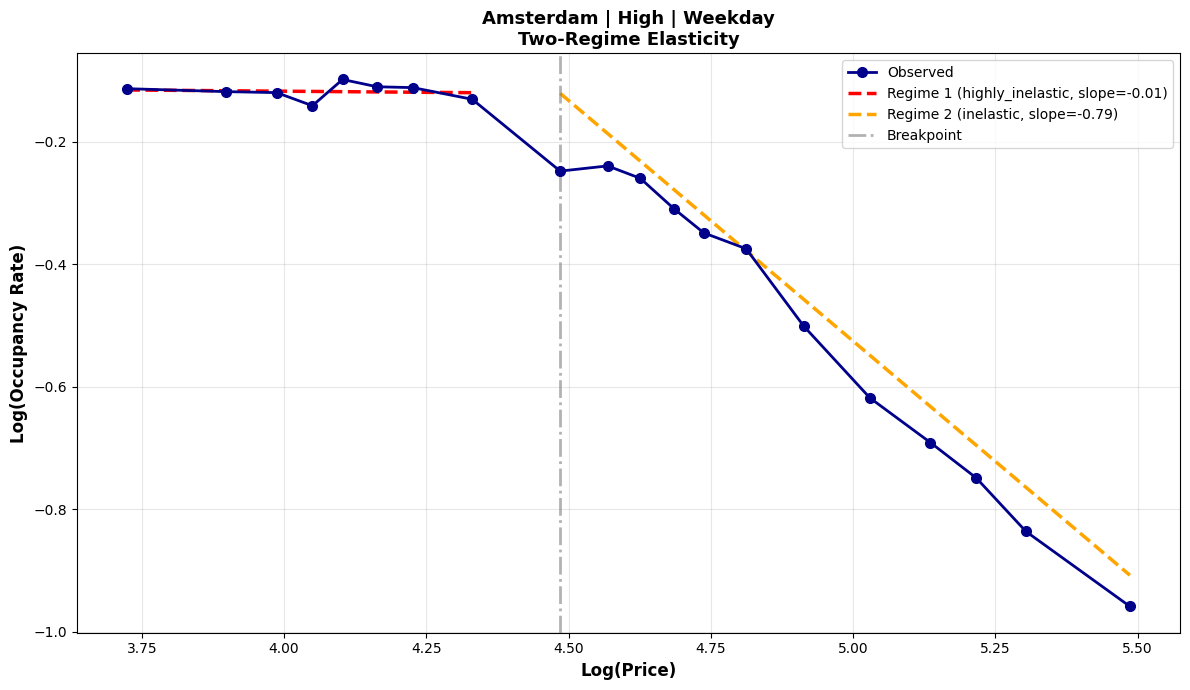


    WEEKEND:
      Rows in segment: 2,080
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 8/20)
        Regime 1: slope=0.03 (highly_inelastic), R²=0.39
        Regime 2: slope=-0.70 (inelastic), R²=0.96


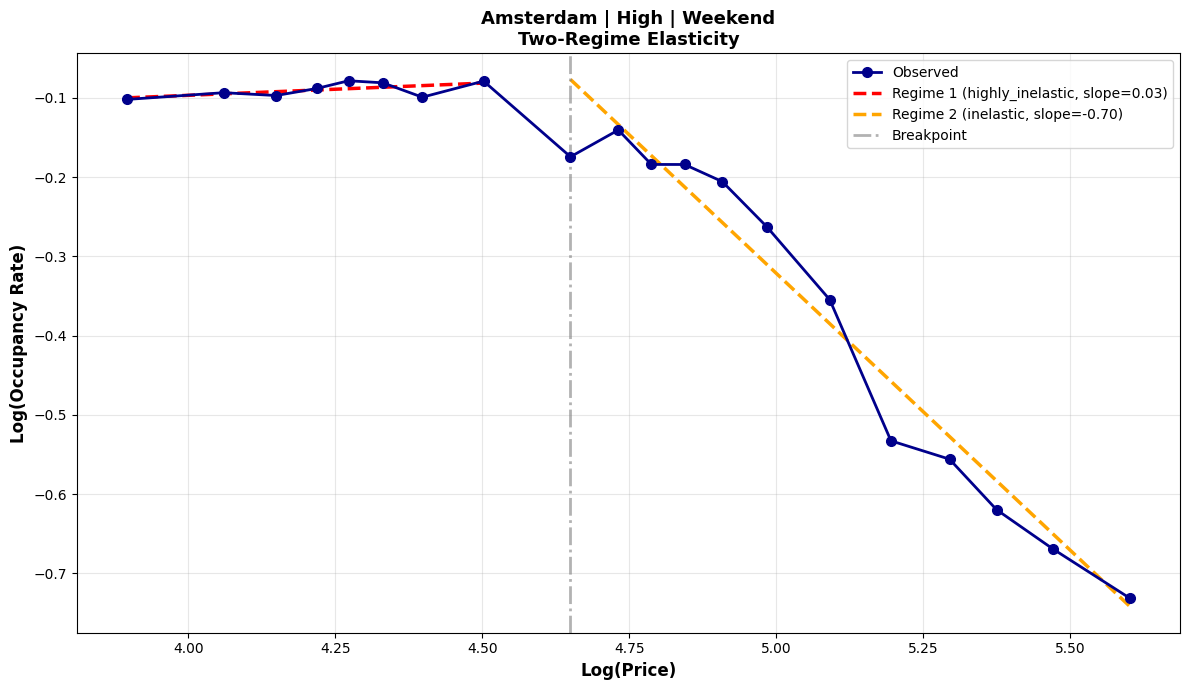


  ────────────────────────────────────────────────────────────
  Season: SHOULDER
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 2,080
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 7/20)
        Regime 1: slope=-0.13 (highly_inelastic), R²=0.57
        Regime 2: slope=-0.95 (inelastic), R²=0.99


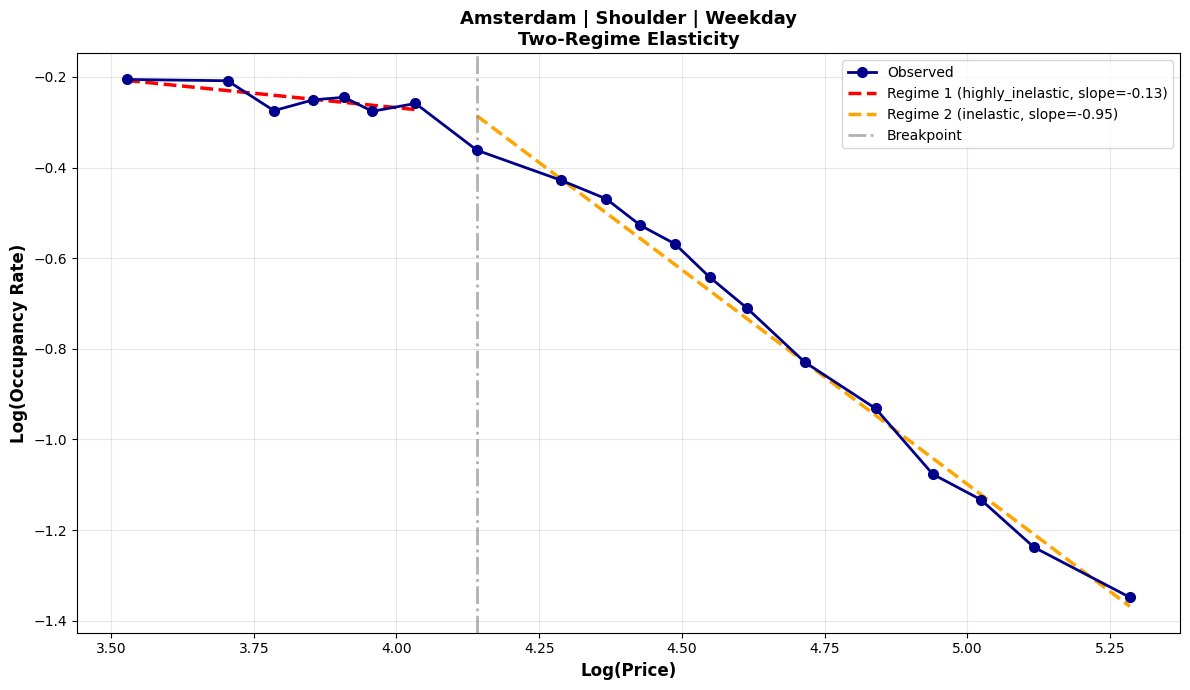


    WEEKEND:
      Rows in segment: 2,080
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 8/20)
        Regime 1: slope=-0.08 (highly_inelastic), R²=0.69
        Regime 2: slope=-0.87 (inelastic), R²=0.99


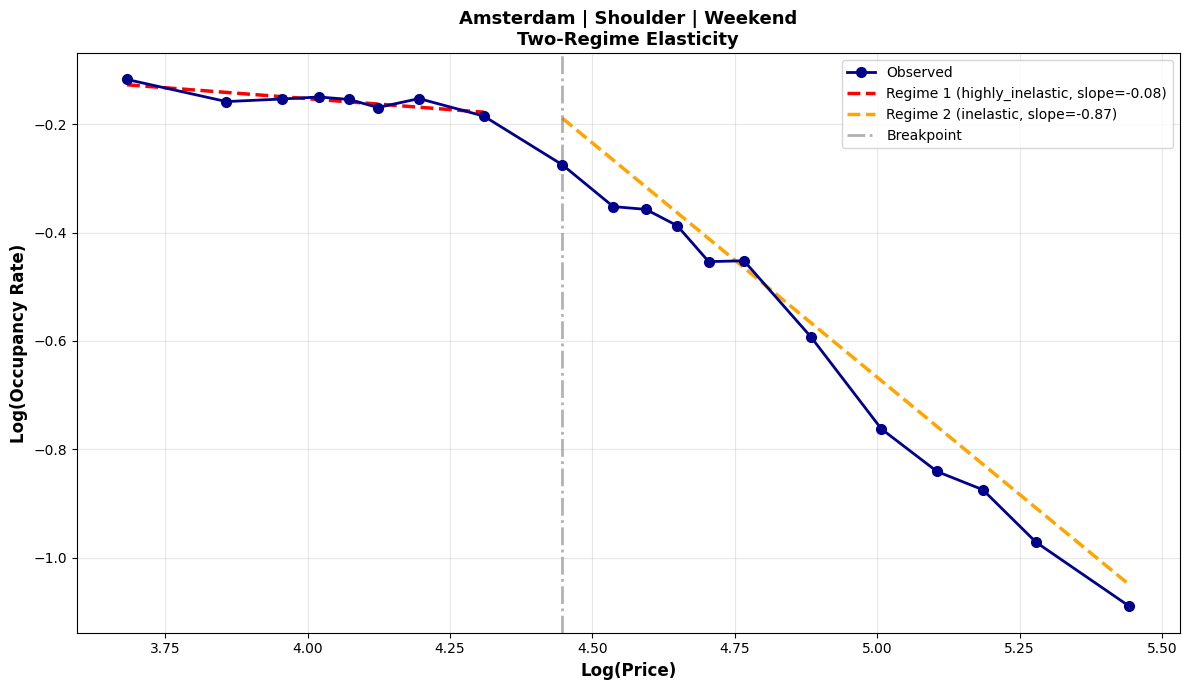


  ────────────────────────────────────────────────────────────
  Season: LOW
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 2,080
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 8/20)
        Regime 1: slope=-0.33 (inelastic), R²=0.95
        Regime 2: slope=-1.11 (elastic), R²=0.99


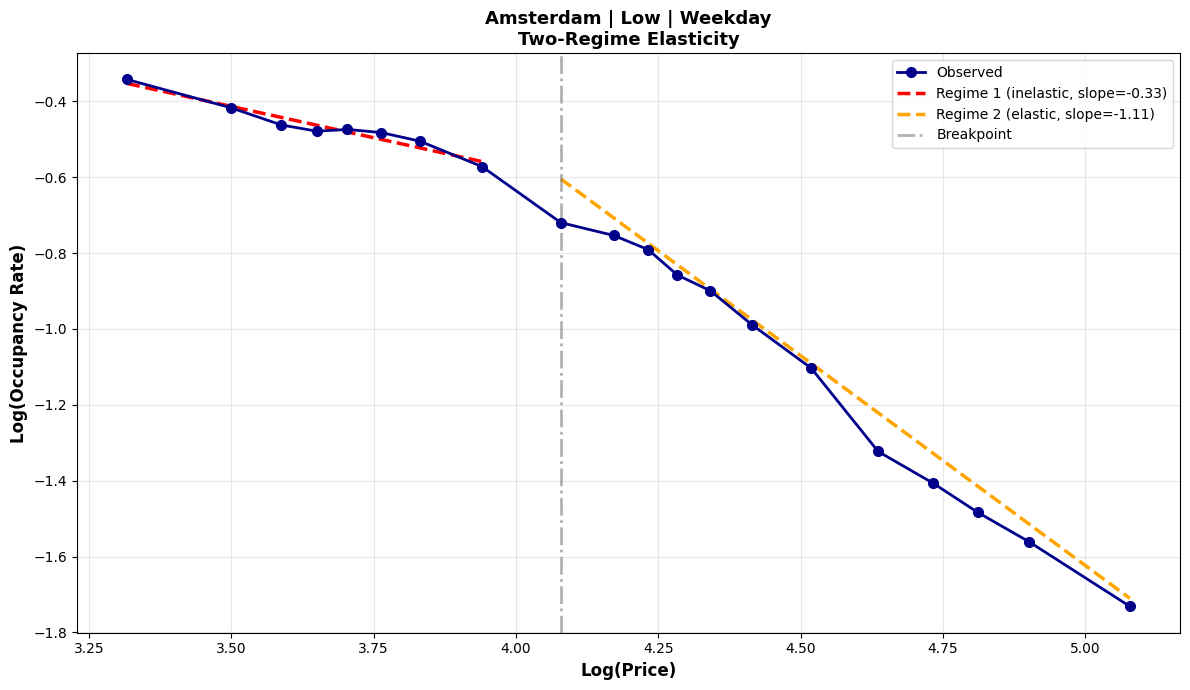


    WEEKEND:
      Rows in segment: 2,080
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 8/20)
        Regime 1: slope=-0.22 (inelastic), R²=0.71
        Regime 2: slope=-0.94 (inelastic), R²=0.98


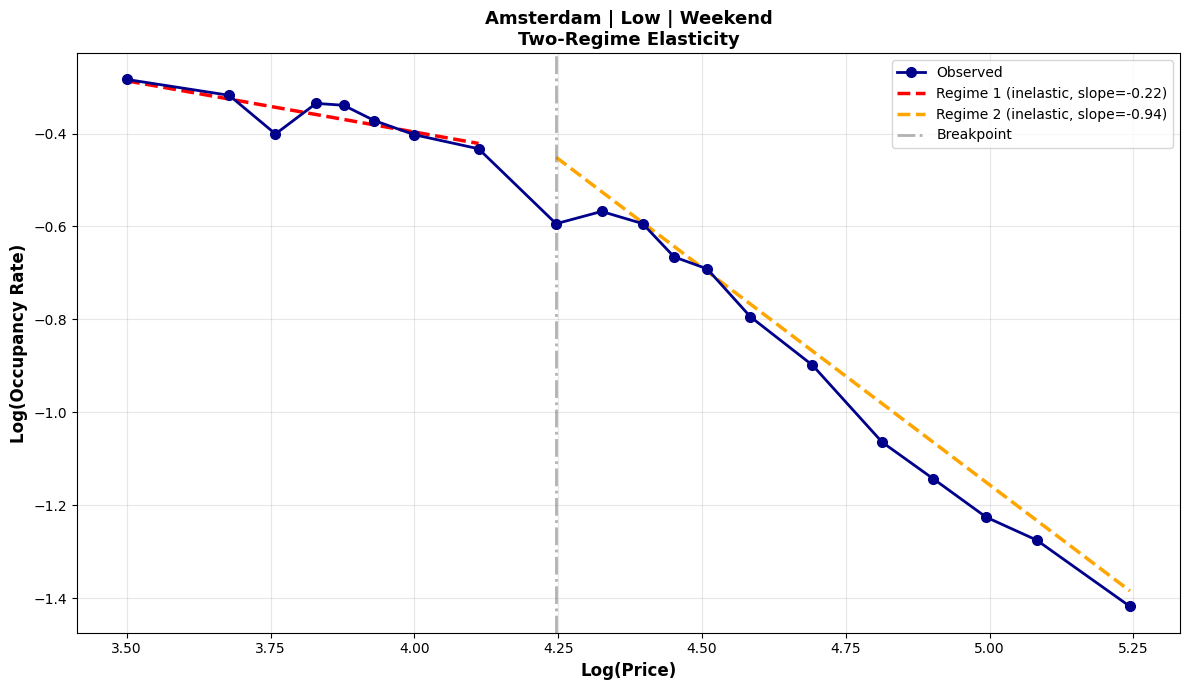


Processing elasticity for city: ATHENS
Total valid rows for athens: 31,680

  ────────────────────────────────────────────────────────────
  Season: HIGH
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 5,280
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 10/20)
        Regime 1: slope=-0.20 (inelastic), R²=0.93
        Regime 2: slope=-0.81 (inelastic), R²=0.99


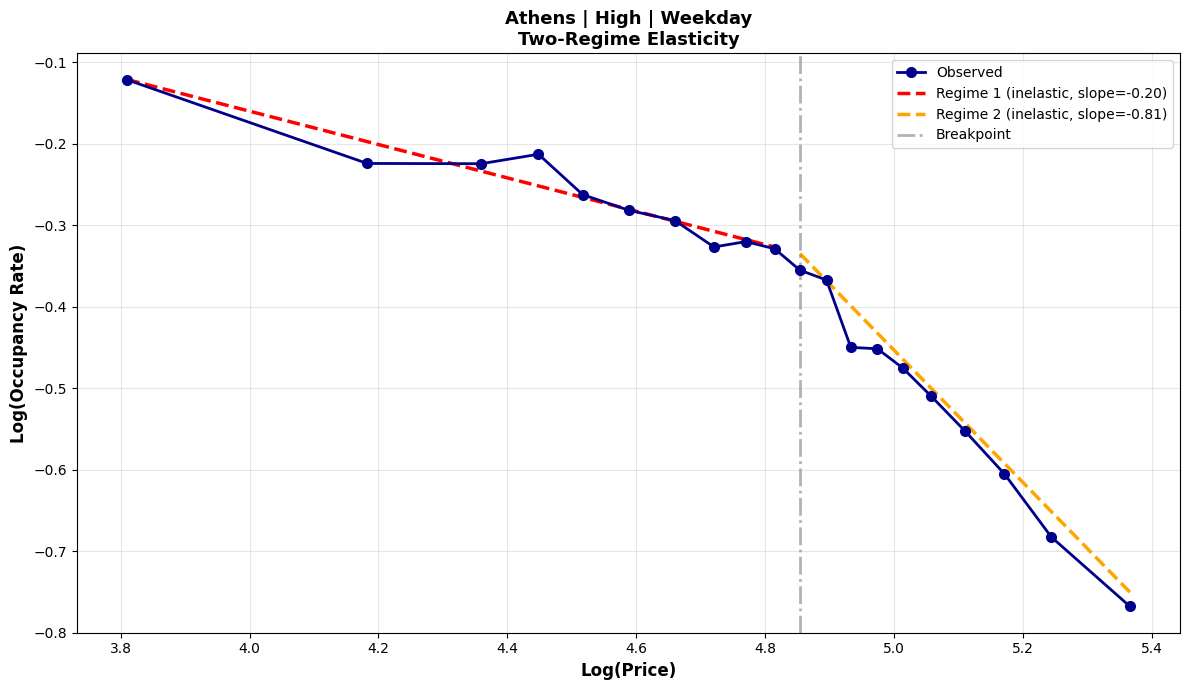


    WEEKEND:
      Rows in segment: 5,280
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 14/20)
        Regime 1: slope=-0.18 (inelastic), R²=0.83
        Regime 2: slope=-0.81 (inelastic), R²=0.98


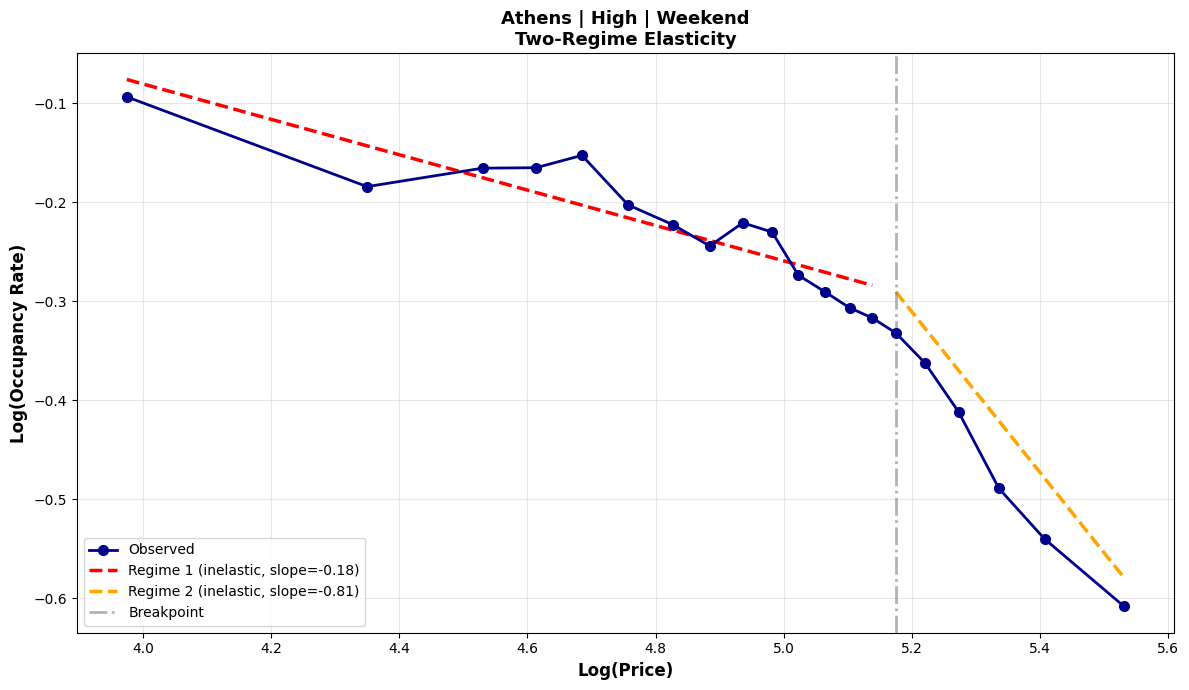


  ────────────────────────────────────────────────────────────
  Season: SHOULDER
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 5,280
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 11/20)
        Regime 1: slope=-0.41 (inelastic), R²=0.99
        Regime 2: slope=-1.01 (unit_elastic), R²=1.00


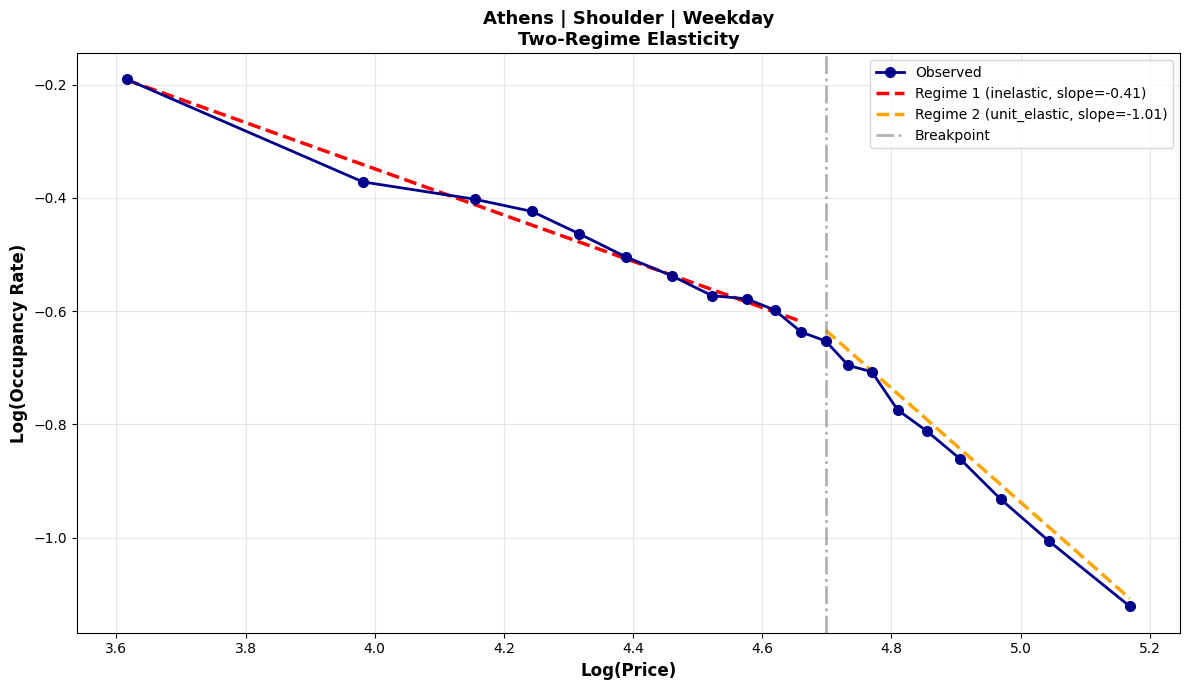


    WEEKEND:
      Rows in segment: 5,280
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 11/20)
        Regime 1: slope=-0.31 (inelastic), R²=0.95
        Regime 2: slope=-0.95 (inelastic), R²=0.99


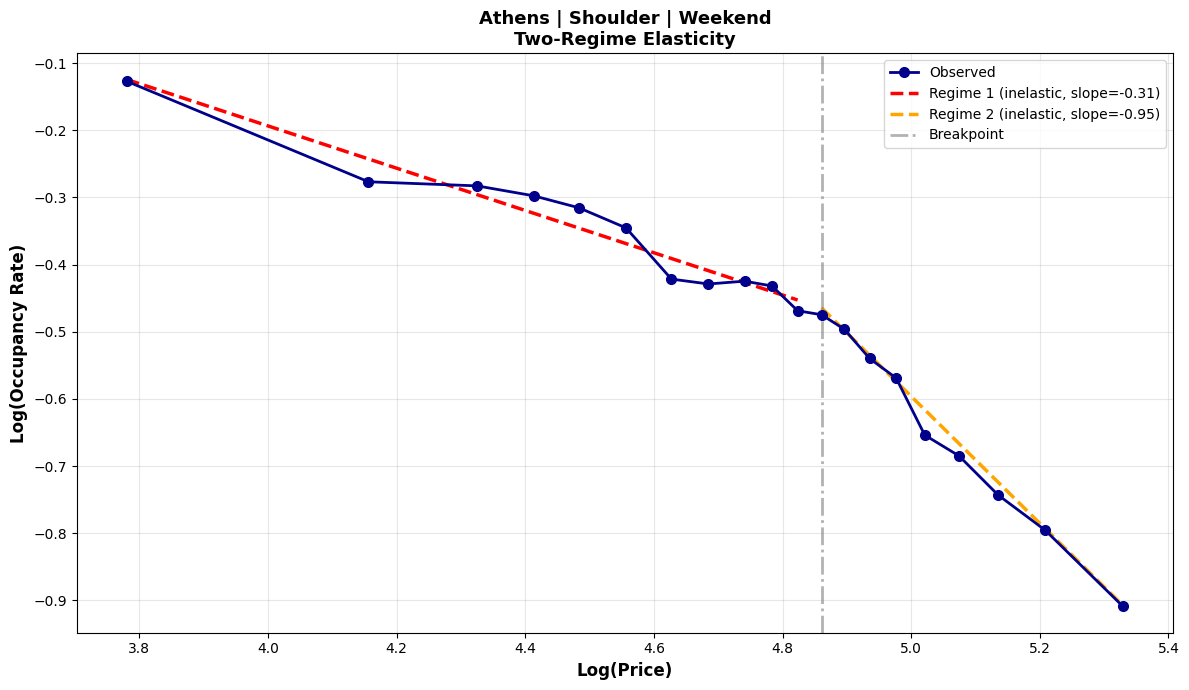


  ────────────────────────────────────────────────────────────
  Season: LOW
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 5,280
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 11/20)
        Regime 1: slope=-0.51 (inelastic), R²=0.97
        Regime 2: slope=-1.14 (elastic), R²=1.00


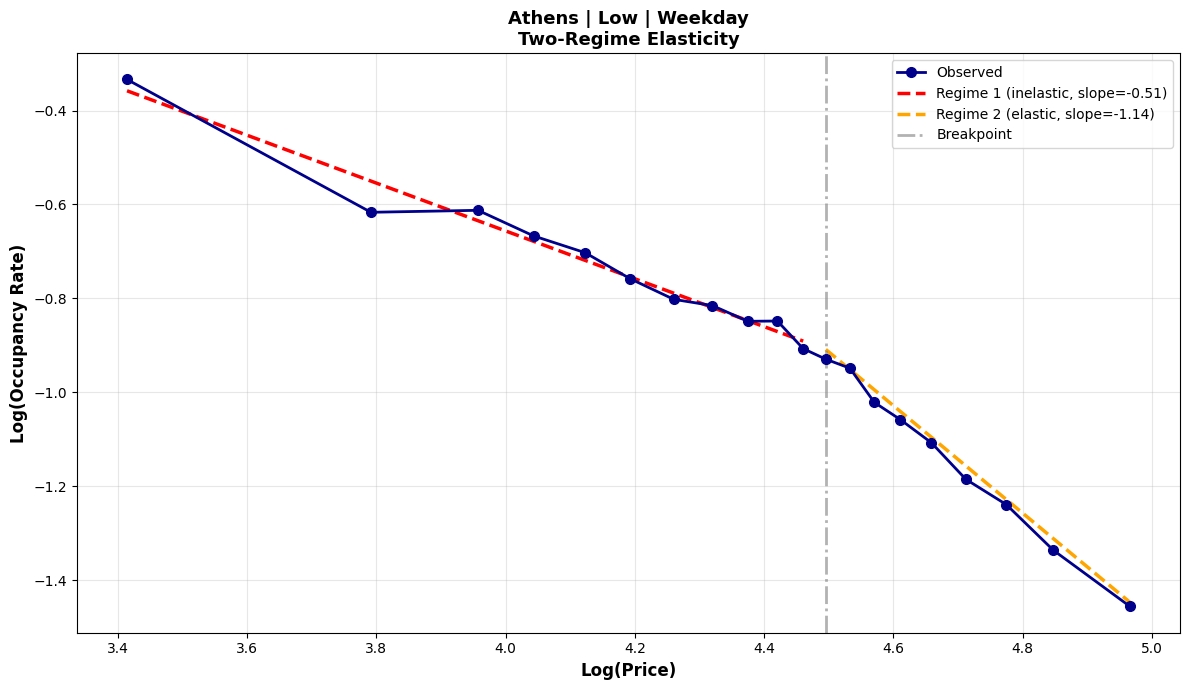


    WEEKEND:
      Rows in segment: 5,280
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 10/20)
        Regime 1: slope=-0.40 (inelastic), R²=0.95
        Regime 2: slope=-0.98 (unit_elastic), R²=0.99


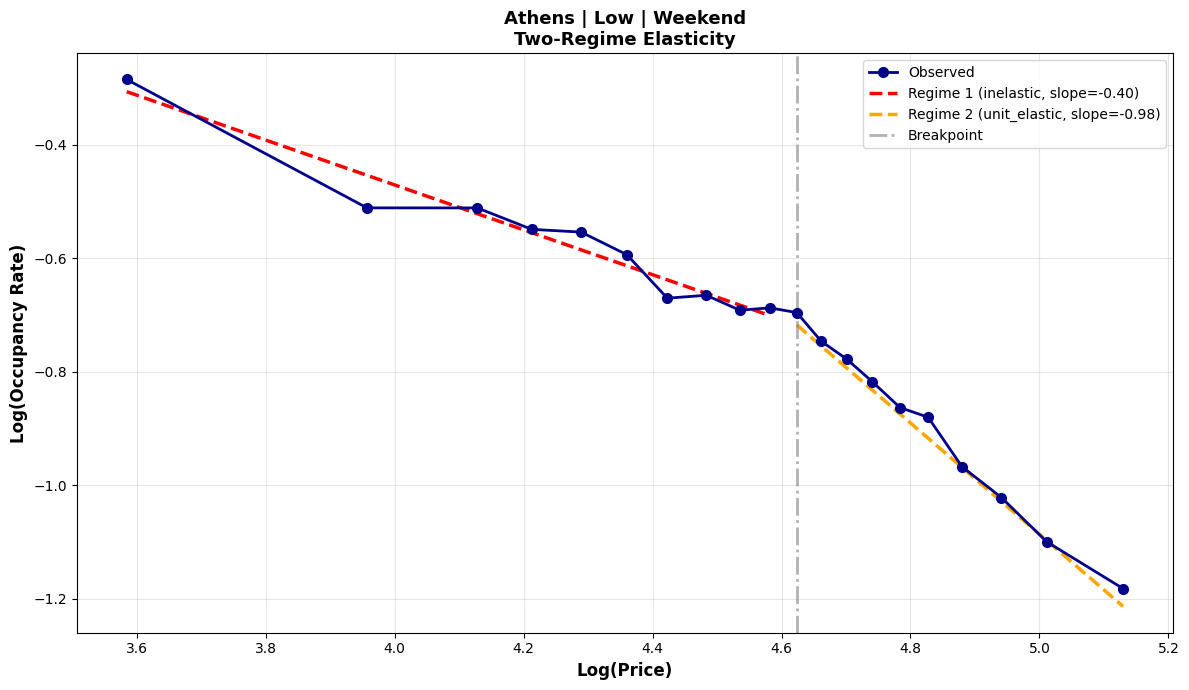


Processing elasticity for city: BARCELONA
Total valid rows for barcelona: 16,998

  ────────────────────────────────────────────────────────────
  Season: HIGH
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 2,833
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 3/20)
        Regime 1: slope=0.14 (highly_inelastic), R²=0.60
        Regime 2: slope=-0.86 (inelastic), R²=0.98


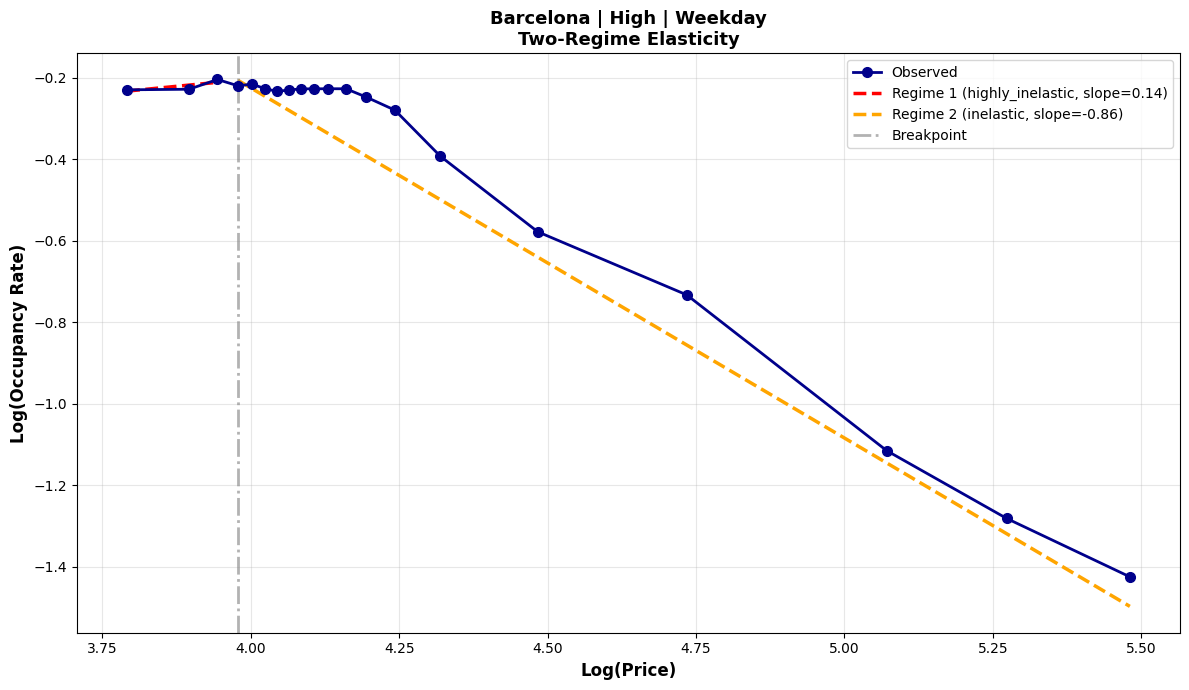


    WEEKEND:
      Rows in segment: 2,833
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 10/20)
        Regime 1: slope=0.16 (positive), R²=0.81
        Regime 2: slope=-0.80 (inelastic), R²=1.00


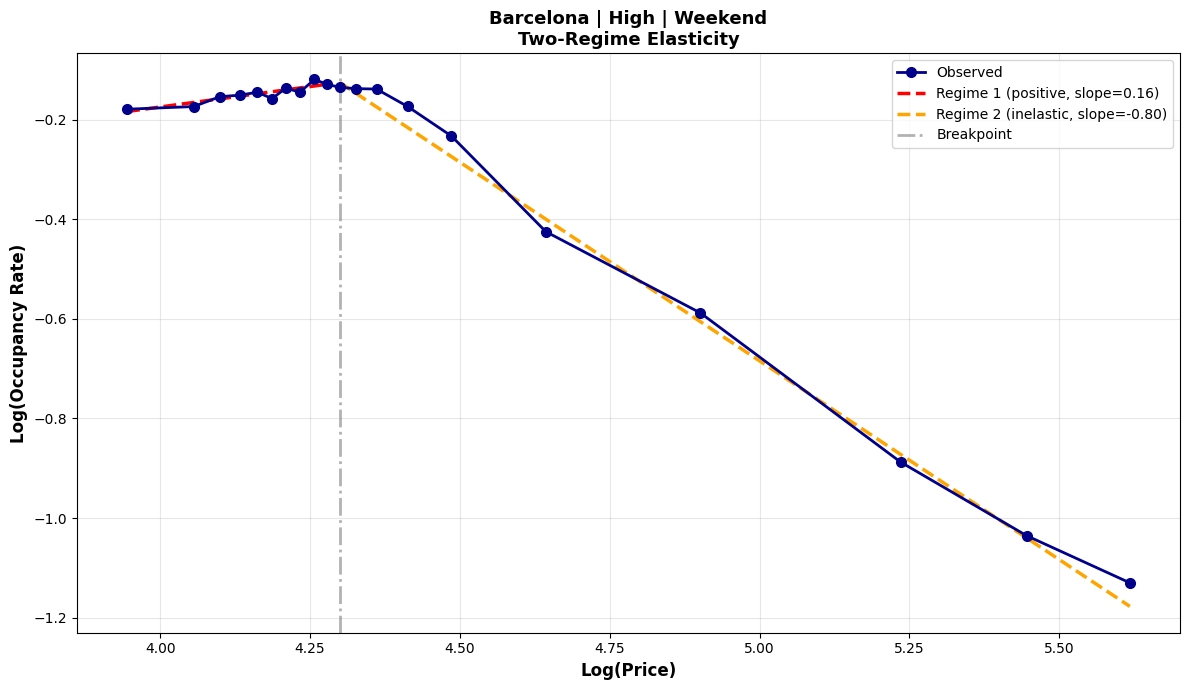


  ────────────────────────────────────────────────────────────
  Season: SHOULDER
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 2,833
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 6/20)
        Regime 1: slope=0.08 (highly_inelastic), R²=0.11
        Regime 2: slope=-1.06 (elastic), R²=1.00


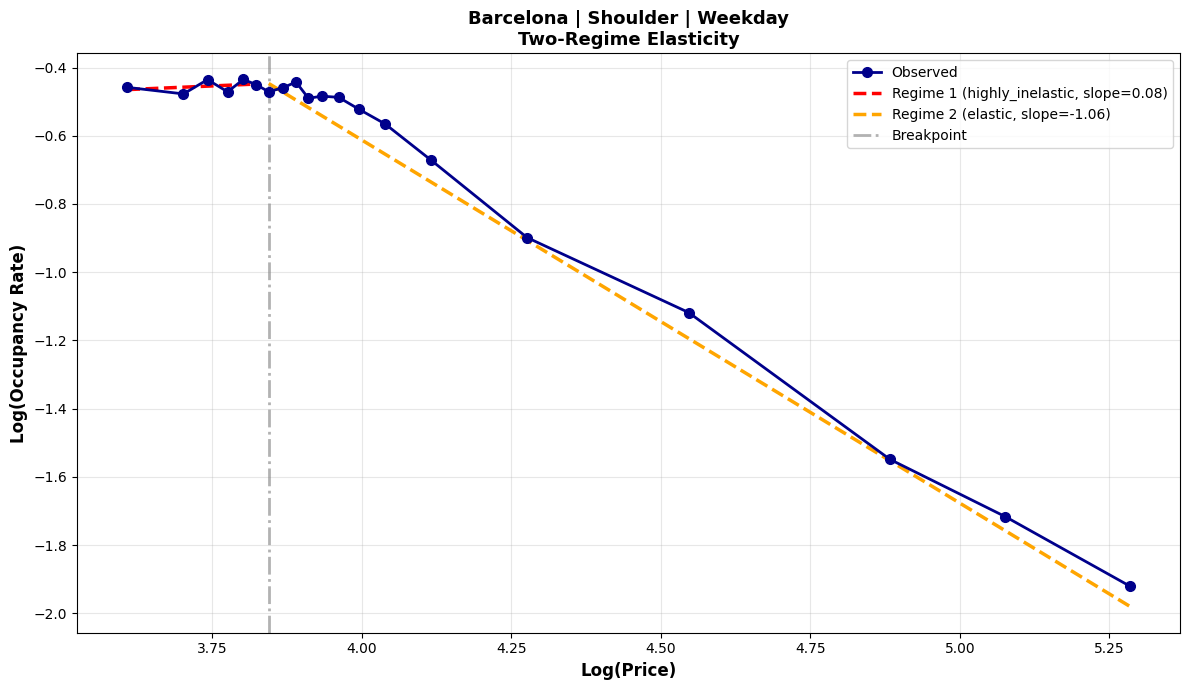


    WEEKEND:
      Rows in segment: 2,833
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 4/20)
        Regime 1: slope=0.13 (highly_inelastic), R²=0.49
        Regime 2: slope=-0.96 (unit_elastic), R²=0.99


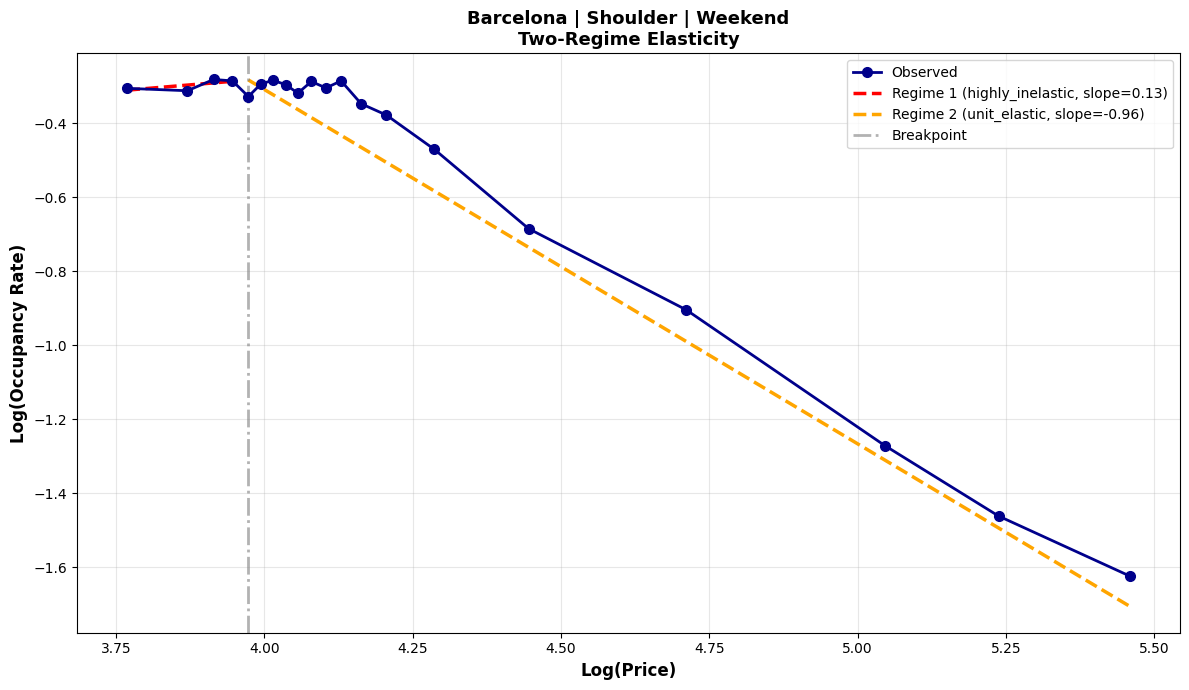


  ────────────────────────────────────────────────────────────
  Season: LOW
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 2,833
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 6/20)
        Regime 1: slope=-0.16 (inelastic), R²=0.57
        Regime 2: slope=-1.20 (elastic), R²=0.99



    WEEKEND:
      Rows in segment: 2,833
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 10/20)
        Regime 1: slope=-0.13 (highly_inelastic), R²=0.52
        Regime 2: slope=-1.04 (unit_elastic), R²=1.00



Processing elasticity for city: BERLIN
Total valid rows for berlin: 14,904

  ────────────────────────────────────────────────────────────
  Season: HIGH
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 2,484
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 9/20)
        Regime 1: slope=-0.20 (inelastic), R²=0.85
        Regime 2: slope=-0.88 (inelastic), R²=1.00



    WEEKEND:
      Rows in segment: 2,484
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 10/20)
        Regime 1: slope=-0.10 (highly_inelastic), R²=0.68
        Regime 2: slope=-0.79 (inelastic), R²=0.99


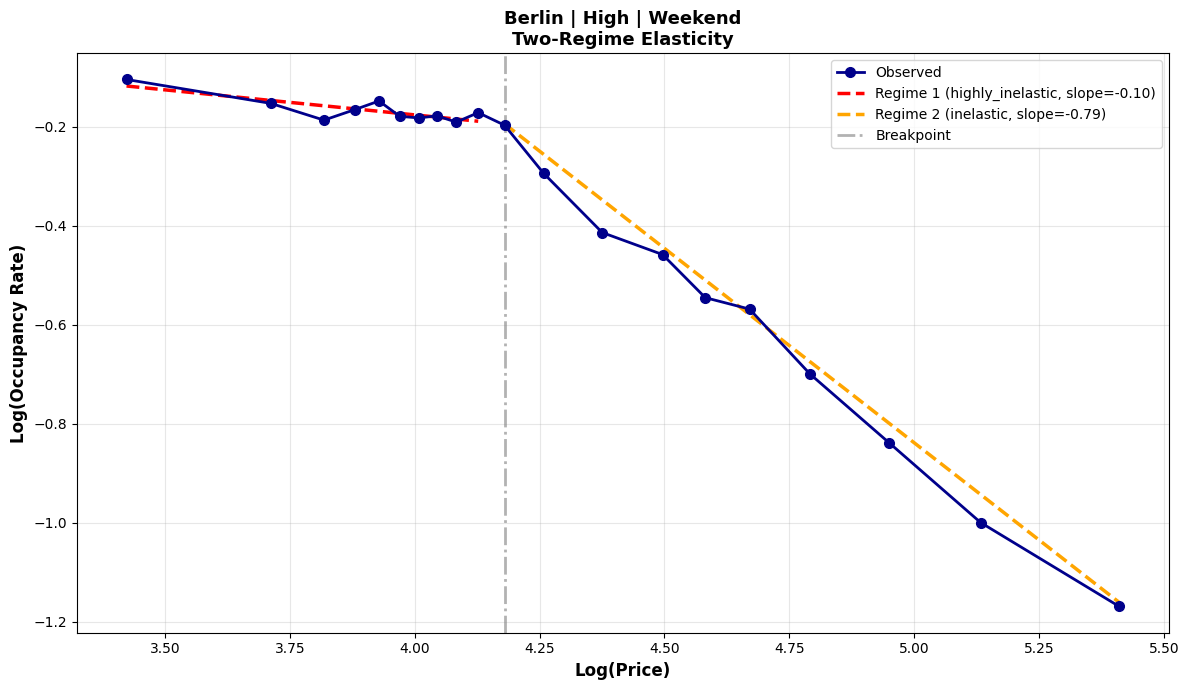


  ────────────────────────────────────────────────────────────
  Season: SHOULDER
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 2,484
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 10/20)
        Regime 1: slope=-0.44 (inelastic), R²=0.98
        Regime 2: slope=-1.08 (elastic), R²=1.00


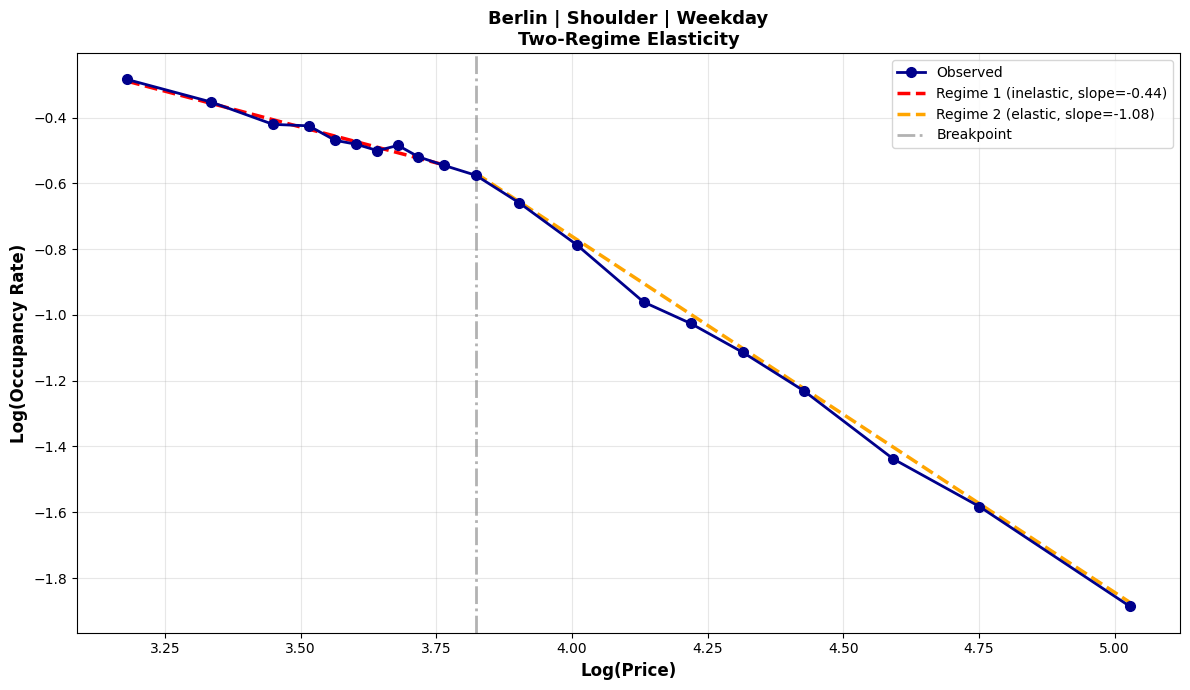


    WEEKEND:
      Rows in segment: 2,484
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 10/20)
        Regime 1: slope=-0.28 (inelastic), R²=0.94
        Regime 2: slope=-0.95 (unit_elastic), R²=0.99


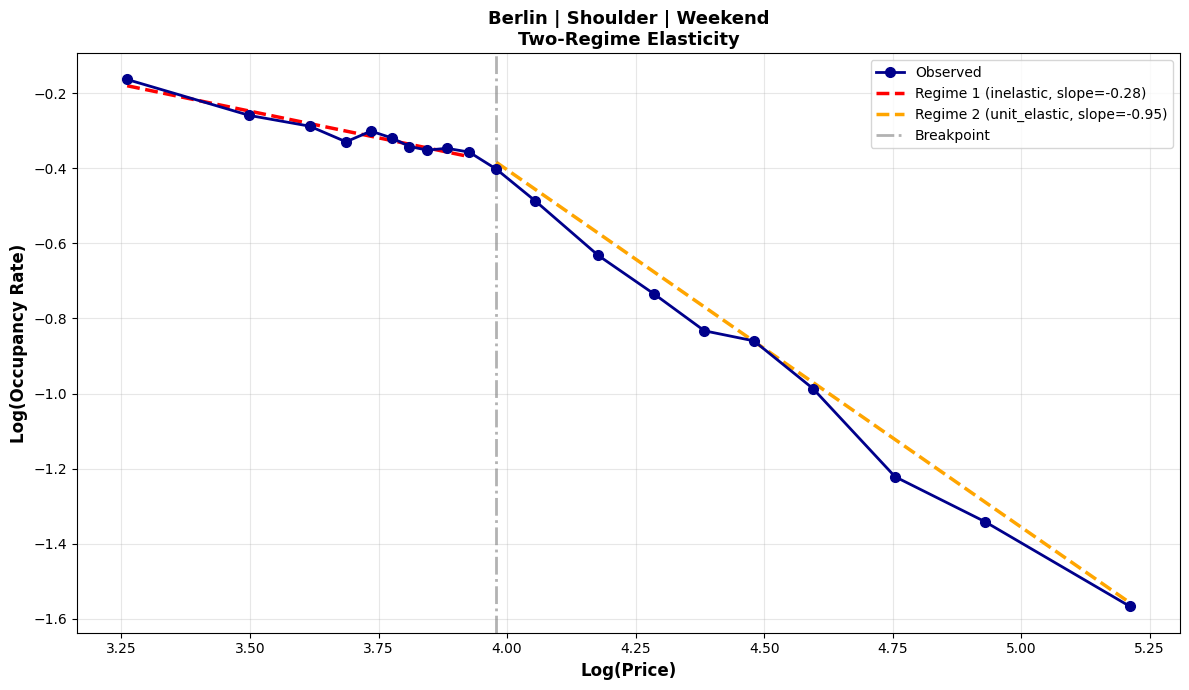


  ────────────────────────────────────────────────────────────
  Season: LOW
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 2,484
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 8/20)
        Regime 1: slope=-0.42 (inelastic), R²=0.87
        Regime 2: slope=-1.17 (elastic), R²=1.00



    WEEKEND:
      Rows in segment: 2,484
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 10/20)
        Regime 1: slope=-0.40 (inelastic), R²=0.85
        Regime 2: slope=-1.02 (unit_elastic), R²=0.99



Processing elasticity for city: BUDAPEST
Total valid rows for budapest: 24,132

  ────────────────────────────────────────────────────────────
  Season: HIGH
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 4,022
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 9/20)
        Regime 1: slope=-0.22 (inelastic), R²=0.90
        Regime 2: slope=-0.80 (inelastic), R²=0.99


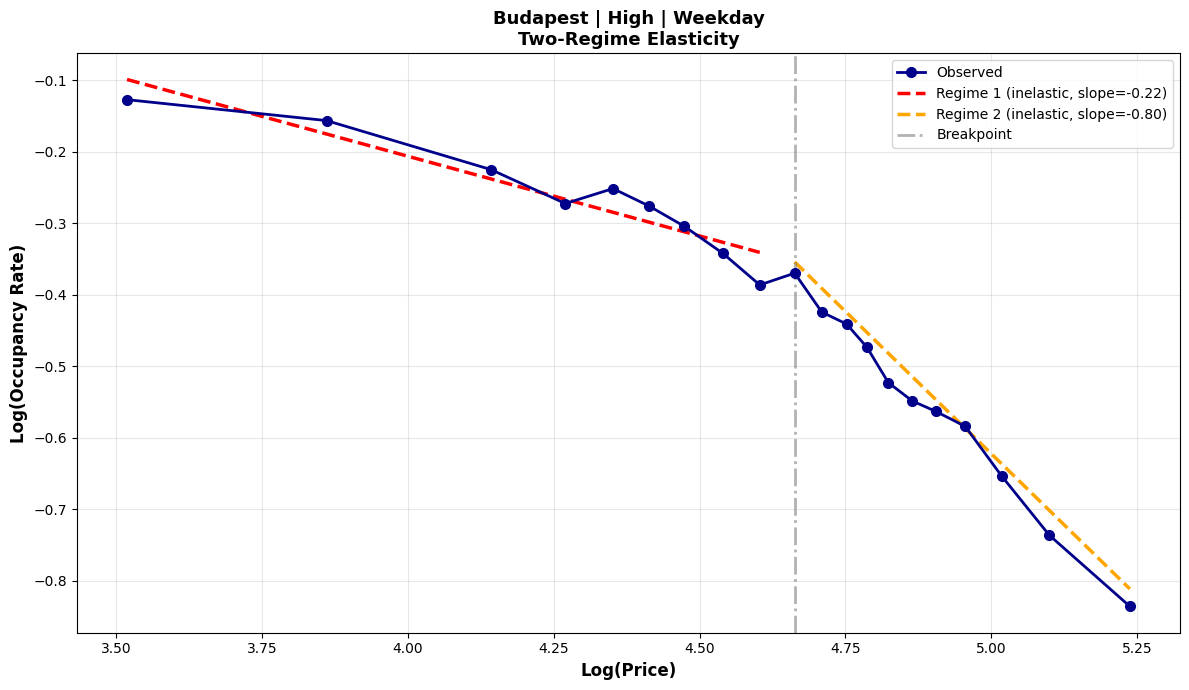


    WEEKEND:
      Rows in segment: 4,022
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 10/20)
        Regime 1: slope=-0.15 (highly_inelastic), R²=0.74
        Regime 2: slope=-0.69 (inelastic), R²=0.99



  ────────────────────────────────────────────────────────────
  Season: SHOULDER
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 4,022
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 11/20)
        Regime 1: slope=-0.44 (inelastic), R²=0.97
        Regime 2: slope=-1.03 (unit_elastic), R²=0.99



    WEEKEND:
      Rows in segment: 4,022
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 10/20)
        Regime 1: slope=-0.31 (inelastic), R²=0.94
        Regime 2: slope=-0.86 (inelastic), R²=0.99


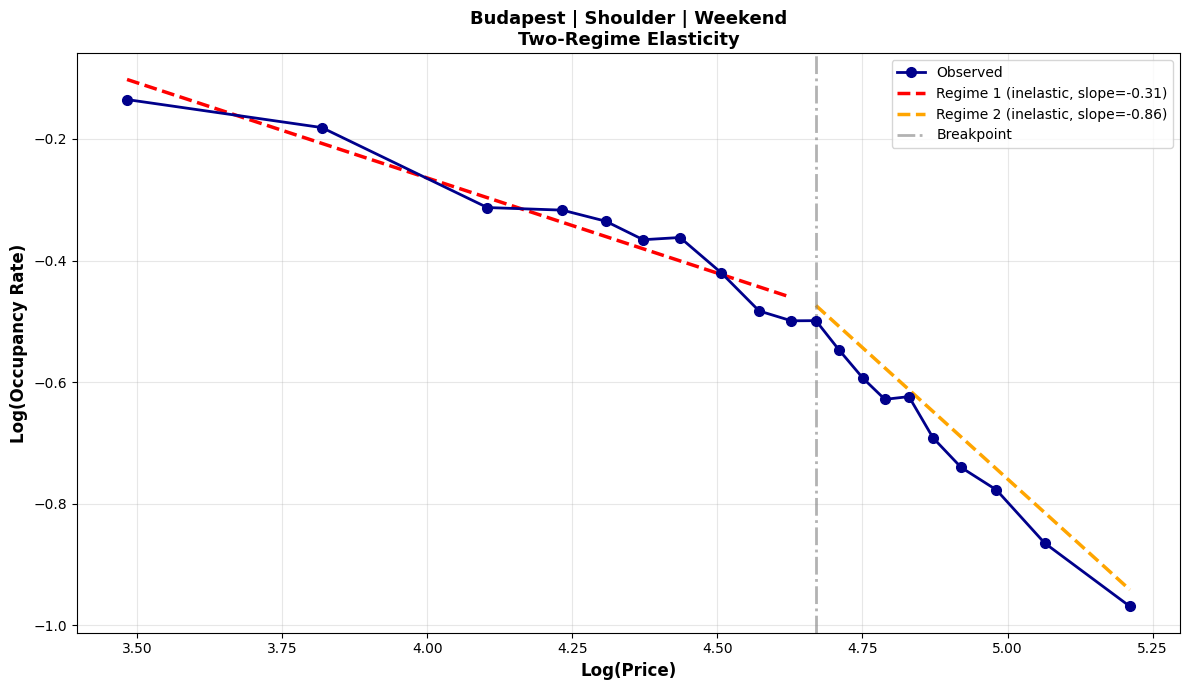


  ────────────────────────────────────────────────────────────
  Season: LOW
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 4,022
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 14/20)
        Regime 1: slope=-0.58 (inelastic), R²=0.98
        Regime 2: slope=-1.22 (elastic), R²=0.99


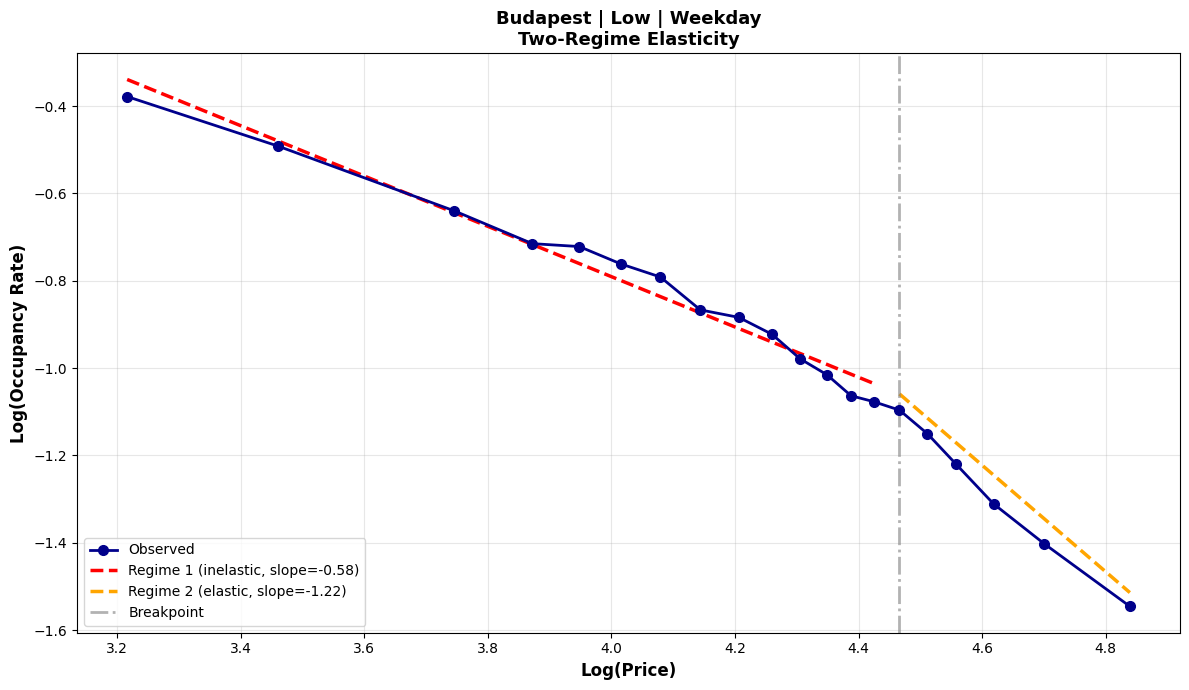


    WEEKEND:
      Rows in segment: 4,022
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 16/20)
        Regime 1: slope=-0.50 (inelastic), R²=0.96
        Regime 2: slope=-1.03 (unit_elastic), R²=0.97



Processing elasticity for city: LISBON
Total valid rows for lisbon: 34,578

  ────────────────────────────────────────────────────────────
  Season: HIGH
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 5,763
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 6/20)
        Regime 1: slope=0.06 (highly_inelastic), R²=0.68
        Regime 2: slope=-0.63 (inelastic), R²=0.96


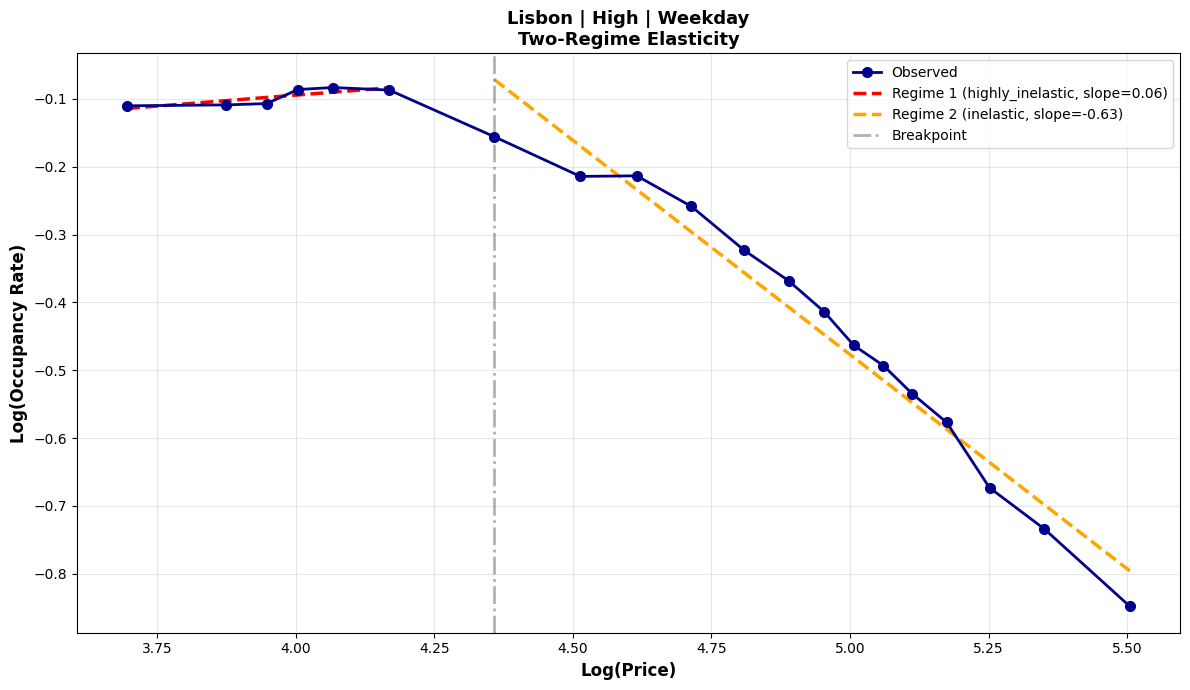


    WEEKEND:
      Rows in segment: 5,763
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 6/20)
        Regime 1: slope=0.07 (highly_inelastic), R²=0.63
        Regime 2: slope=-0.51 (inelastic), R²=0.95



  ────────────────────────────────────────────────────────────
  Season: SHOULDER
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 5,763
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 6/20)
        Regime 1: slope=-0.08 (highly_inelastic), R²=0.64
        Regime 2: slope=-0.84 (inelastic), R²=0.98


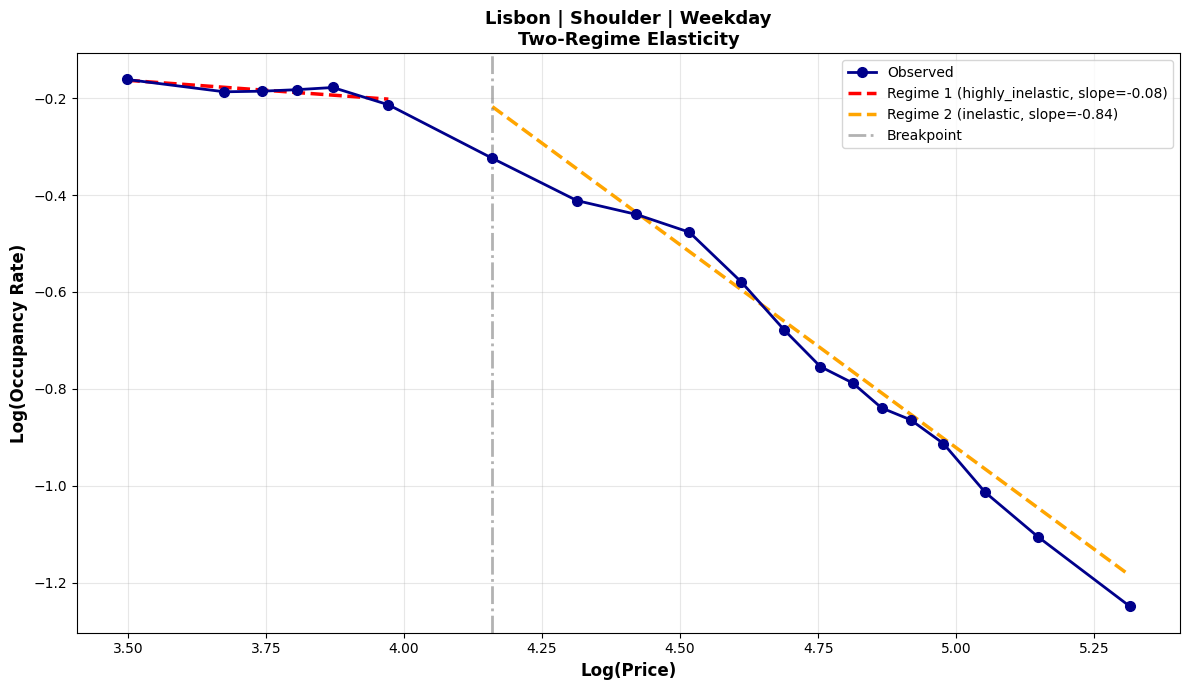


    WEEKEND:
      Rows in segment: 5,763
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 6/20)
        Regime 1: slope=0.01 (highly_inelastic), R²=0.02
        Regime 2: slope=-0.73 (inelastic), R²=0.98


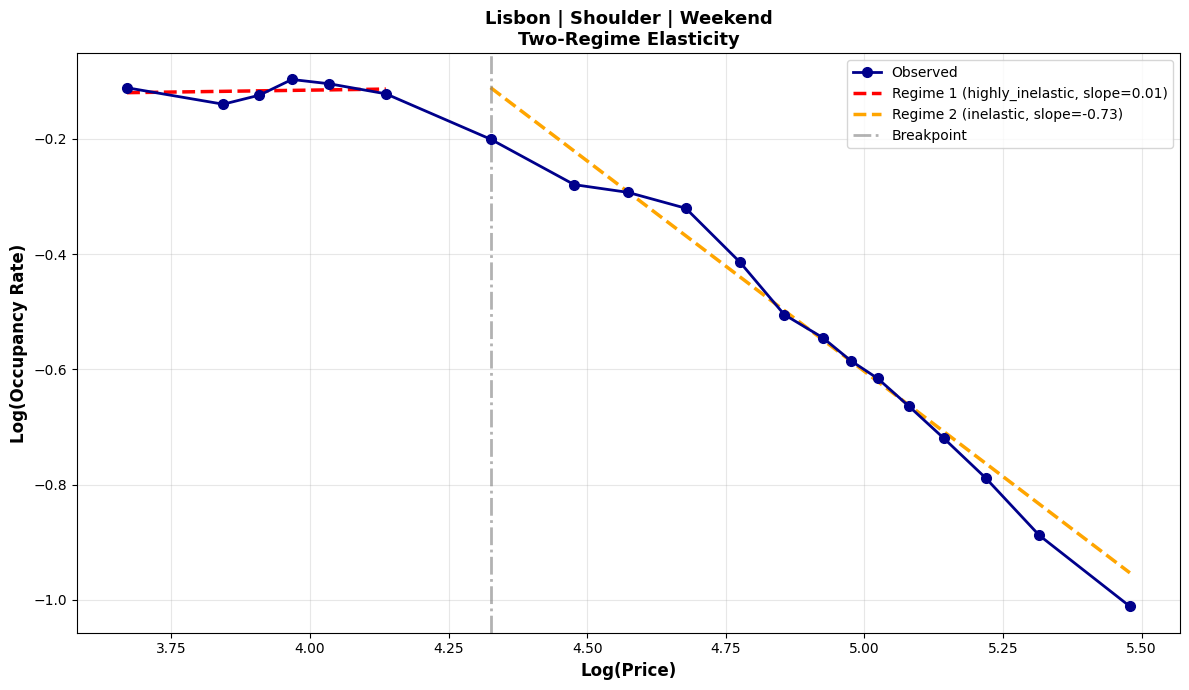


  ────────────────────────────────────────────────────────────
  Season: LOW
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 5,763
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 6/20)
        Regime 1: slope=-0.21 (inelastic), R²=0.83
        Regime 2: slope=-0.93 (inelastic), R²=0.98


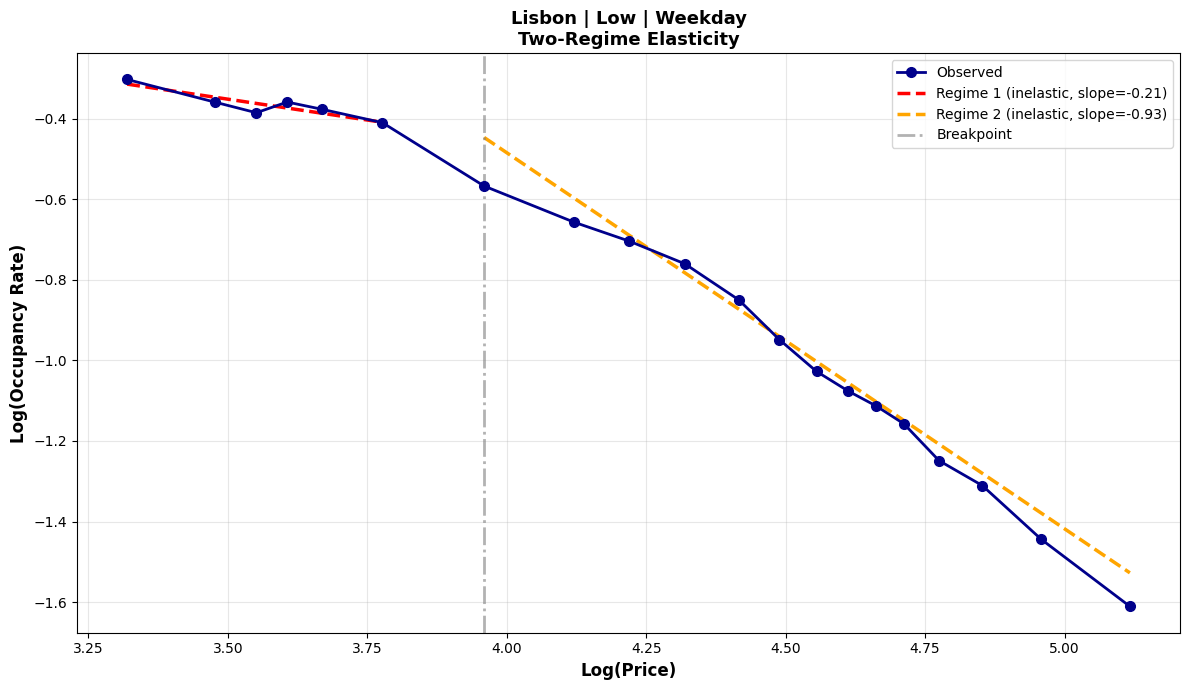


    WEEKEND:
      Rows in segment: 5,763
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 5/20)
        Regime 1: slope=-0.09 (highly_inelastic), R²=0.26
        Regime 2: slope=-0.73 (inelastic), R²=0.97


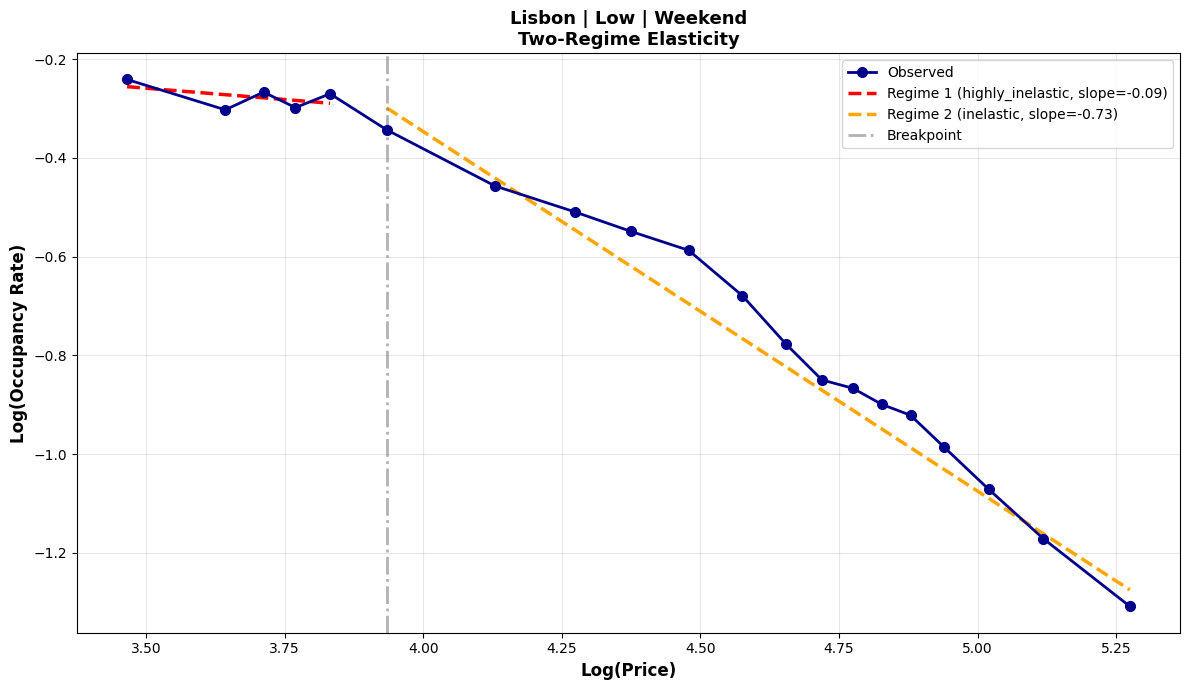


Processing elasticity for city: LONDON
Total valid rows for london: 59,958

  ────────────────────────────────────────────────────────────
  Season: HIGH
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 9,993
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 9/20)
        Regime 1: slope=-0.11 (highly_inelastic), R²=0.97
        Regime 2: slope=-0.85 (inelastic), R²=1.00



    WEEKEND:
      Rows in segment: 9,993
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 10/20)
        Regime 1: slope=-0.05 (highly_inelastic), R²=0.86
        Regime 2: slope=-0.73 (inelastic), R²=0.99


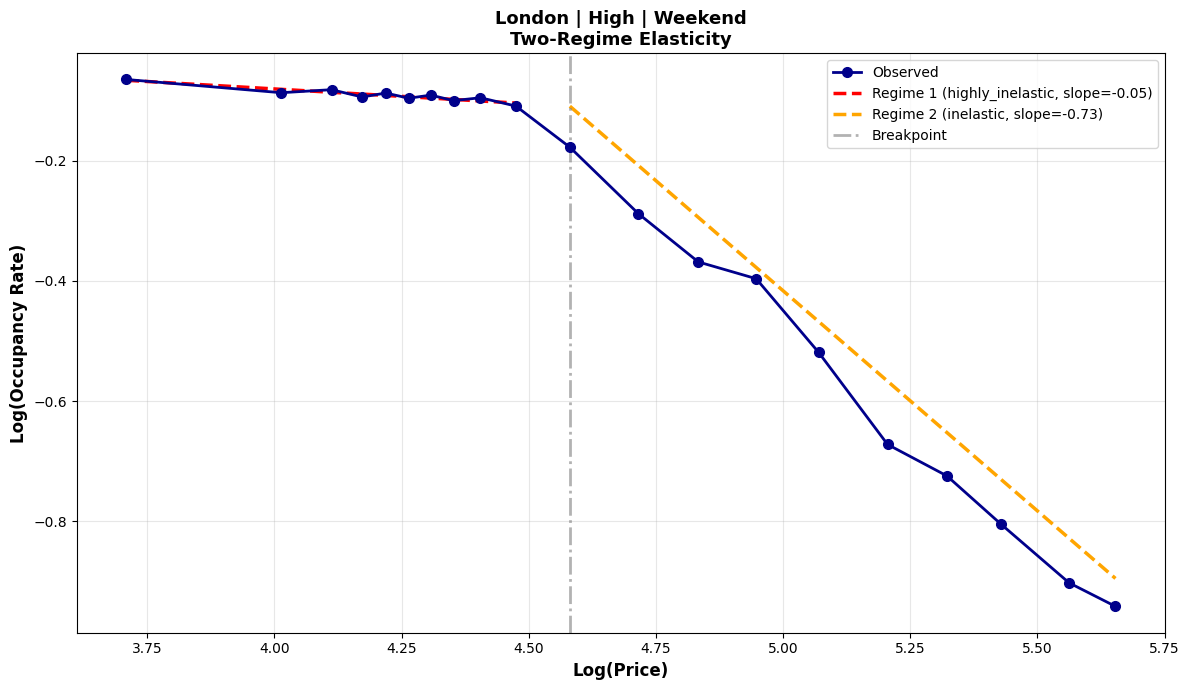


  ────────────────────────────────────────────────────────────
  Season: SHOULDER
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 9,993
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 9/20)
        Regime 1: slope=-0.36 (inelastic), R²=0.99
        Regime 2: slope=-1.03 (unit_elastic), R²=1.00


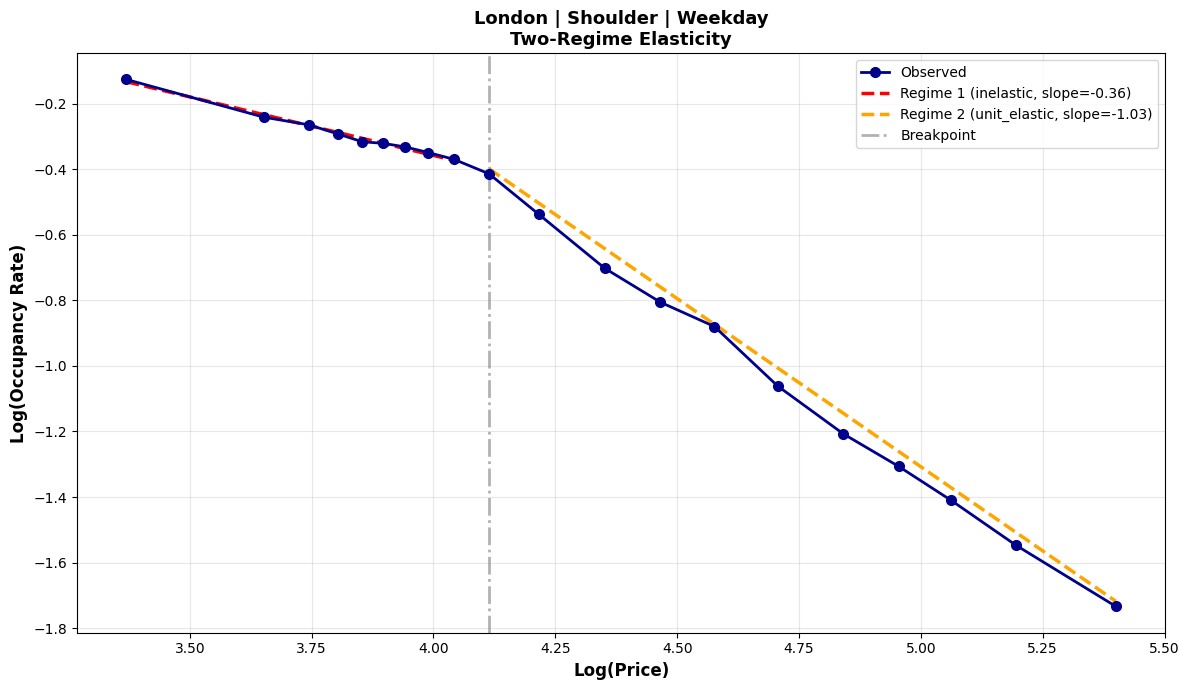


    WEEKEND:
      Rows in segment: 9,993
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 9/20)
        Regime 1: slope=-0.20 (inelastic), R²=0.95
        Regime 2: slope=-0.92 (inelastic), R²=1.00


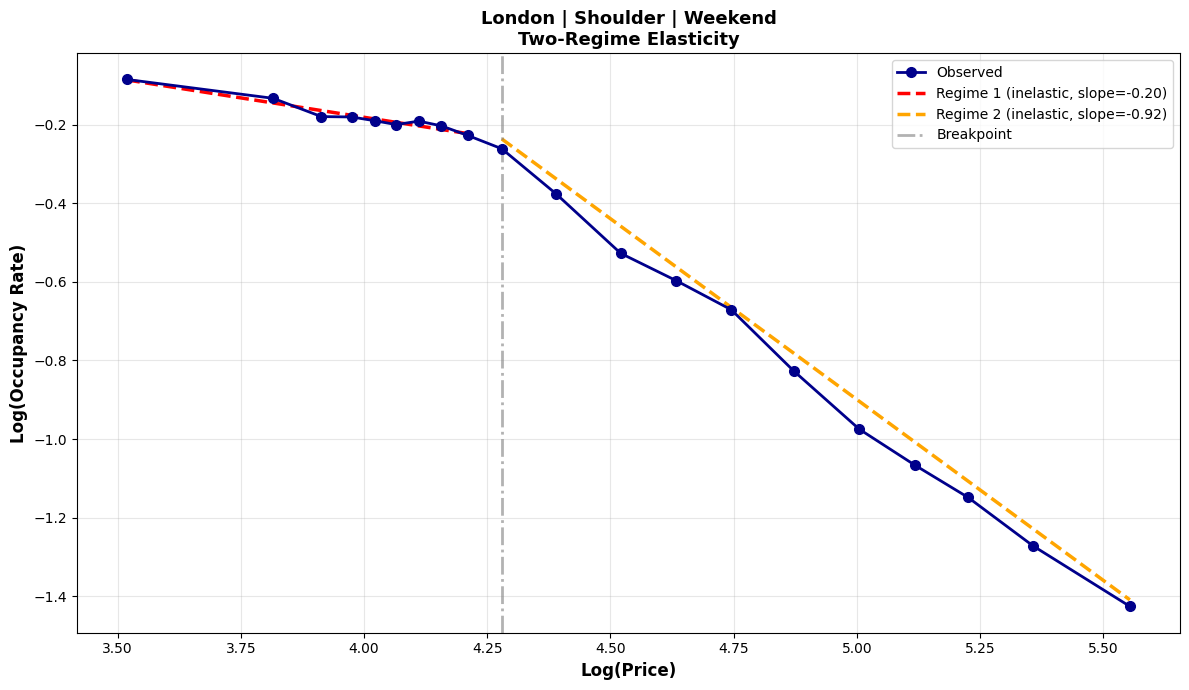


  ────────────────────────────────────────────────────────────
  Season: LOW
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 9,993
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 9/20)
        Regime 1: slope=-0.52 (inelastic), R²=0.99
        Regime 2: slope=-1.16 (elastic), R²=1.00


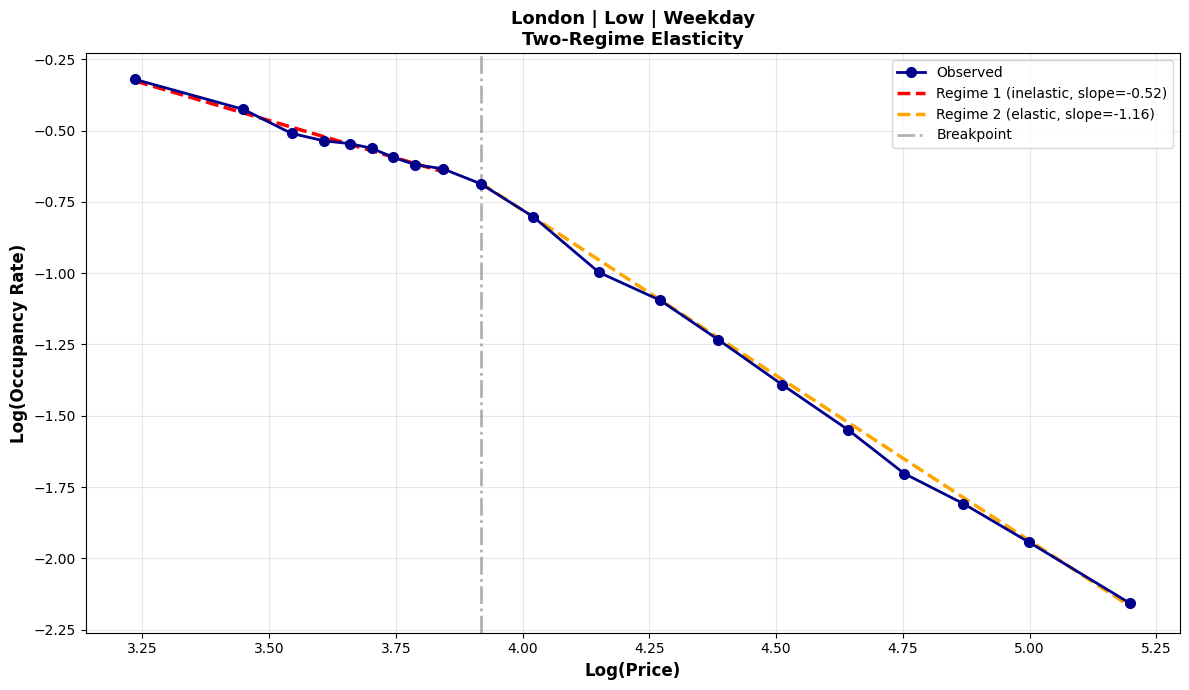


    WEEKEND:
      Rows in segment: 9,993
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 9/20)
        Regime 1: slope=-0.39 (inelastic), R²=0.99
        Regime 2: slope=-0.98 (unit_elastic), R²=1.00


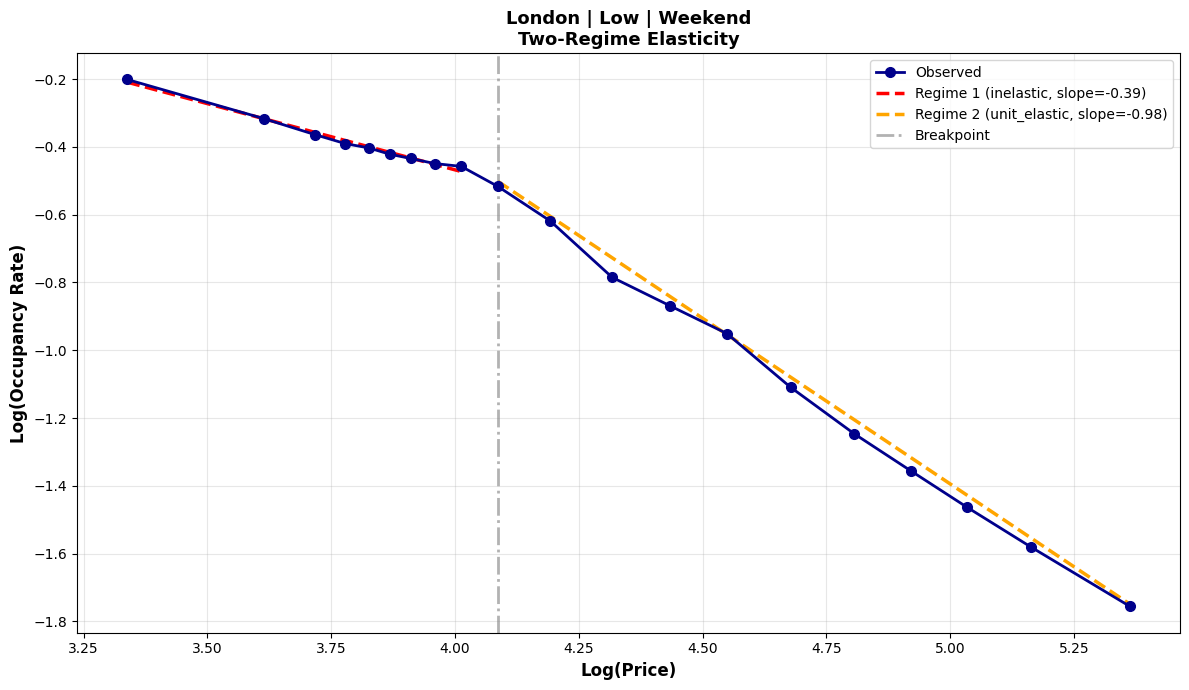


Processing elasticity for city: PARIS
Total valid rows for paris: 40,128

  ────────────────────────────────────────────────────────────
  Season: HIGH
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 6,688
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 3/20)
        Regime 1: slope=0.14 (highly_inelastic), R²=0.98
        Regime 2: slope=-0.62 (inelastic), R²=0.94


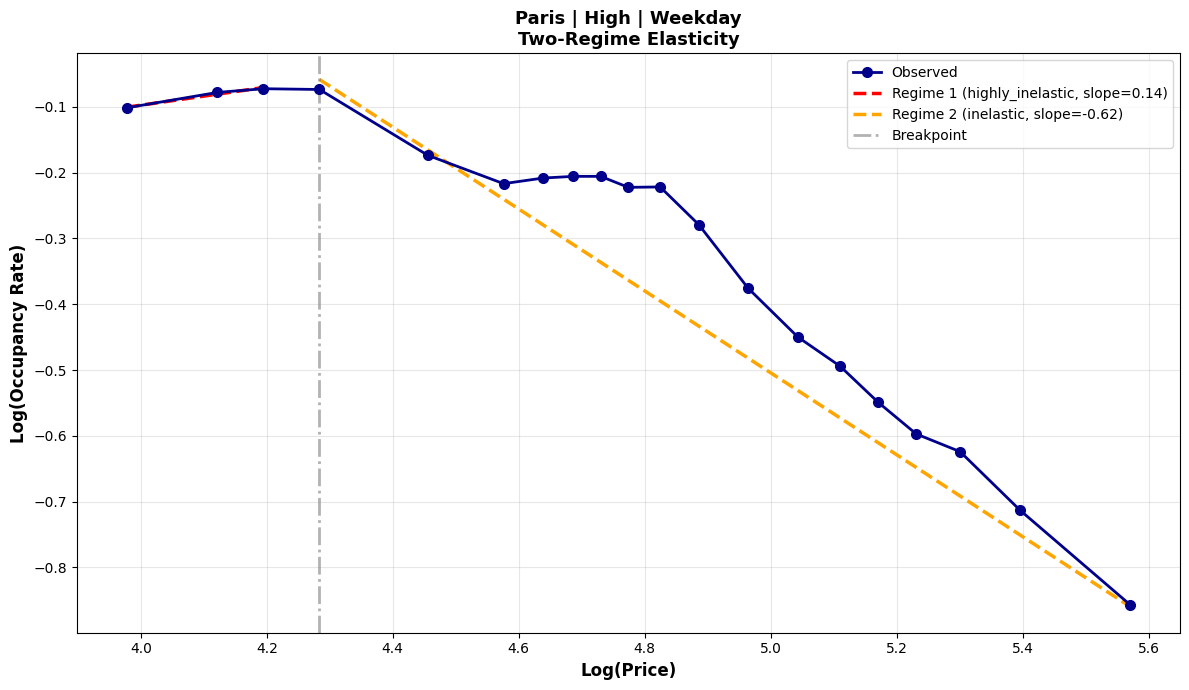


    WEEKEND:
      Rows in segment: 6,688
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 3/20)
        Regime 1: slope=0.12 (highly_inelastic), R²=0.99
        Regime 2: slope=-0.48 (inelastic), R²=0.90


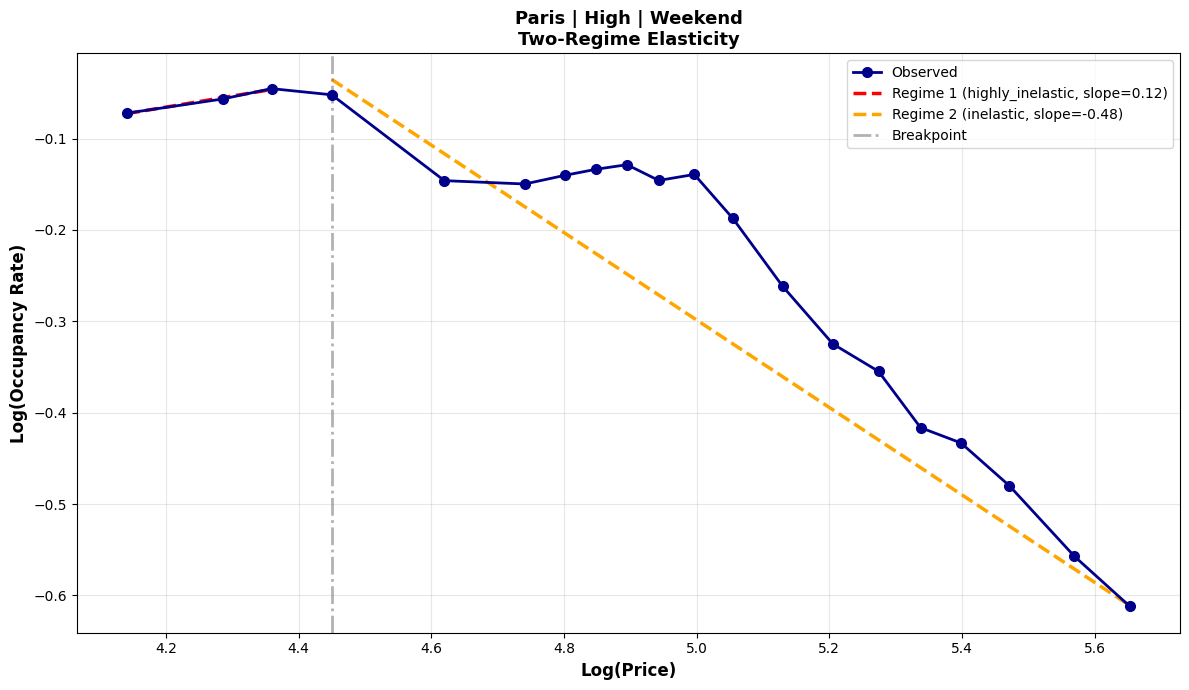


  ────────────────────────────────────────────────────────────
  Season: SHOULDER
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 6,688
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 3/20)
        Regime 1: slope=0.03 (highly_inelastic), R²=0.07
        Regime 2: slope=-0.83 (inelastic), R²=0.97


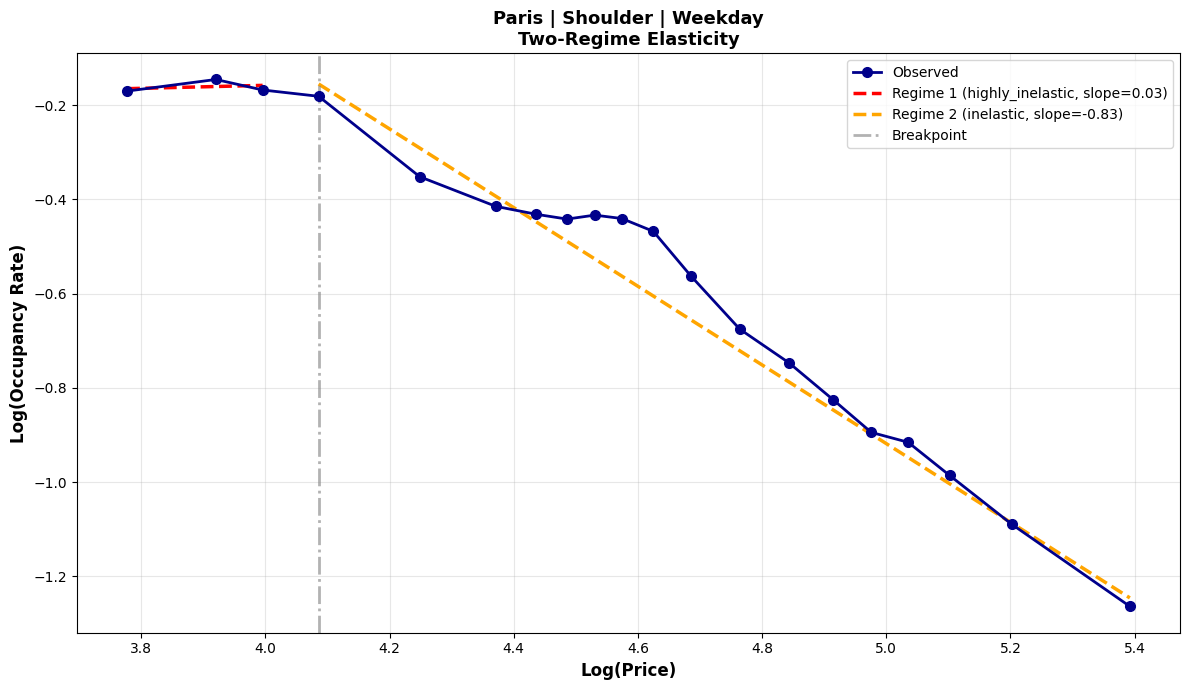


    WEEKEND:
      Rows in segment: 6,688
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 3/20)
        Regime 1: slope=0.10 (highly_inelastic), R²=0.52
        Regime 2: slope=-0.72 (inelastic), R²=0.95



  ────────────────────────────────────────────────────────────
  Season: LOW
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 6,688
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 3/20)
        Regime 1: slope=-0.16 (inelastic), R²=0.99
        Regime 2: slope=-0.95 (unit_elastic), R²=0.97


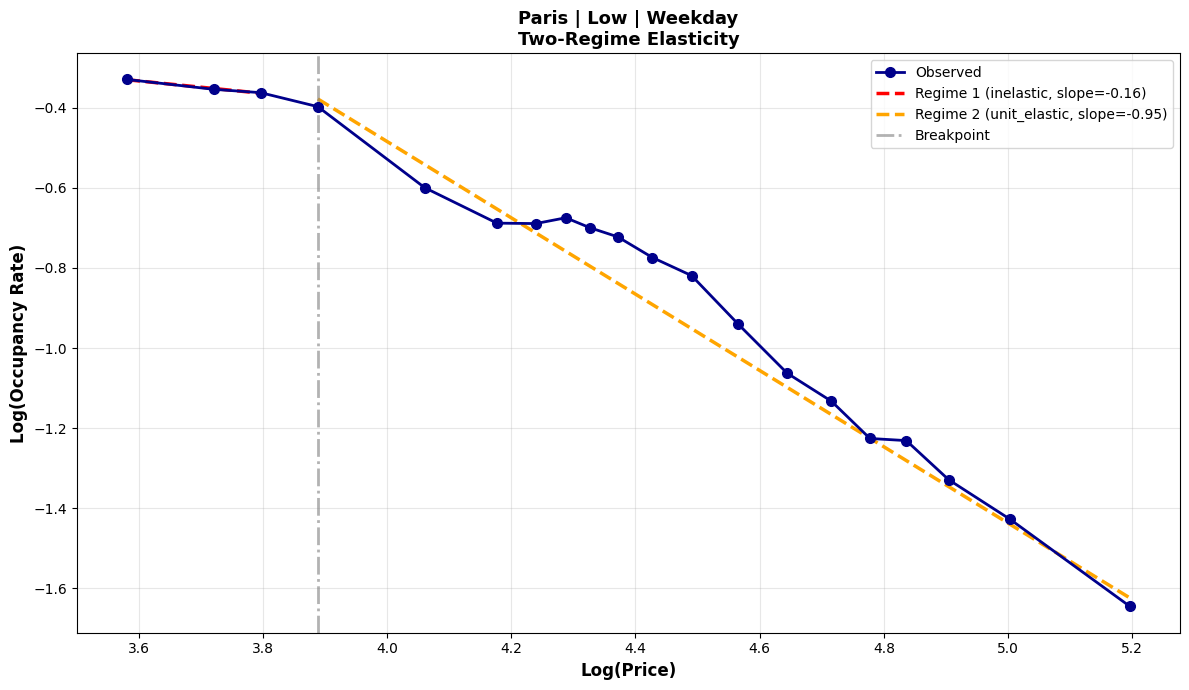


    WEEKEND:
      Rows in segment: 6,688
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 3/20)
        Regime 1: slope=0.05 (highly_inelastic), R²=0.46
        Regime 2: slope=-0.80 (inelastic), R²=0.97


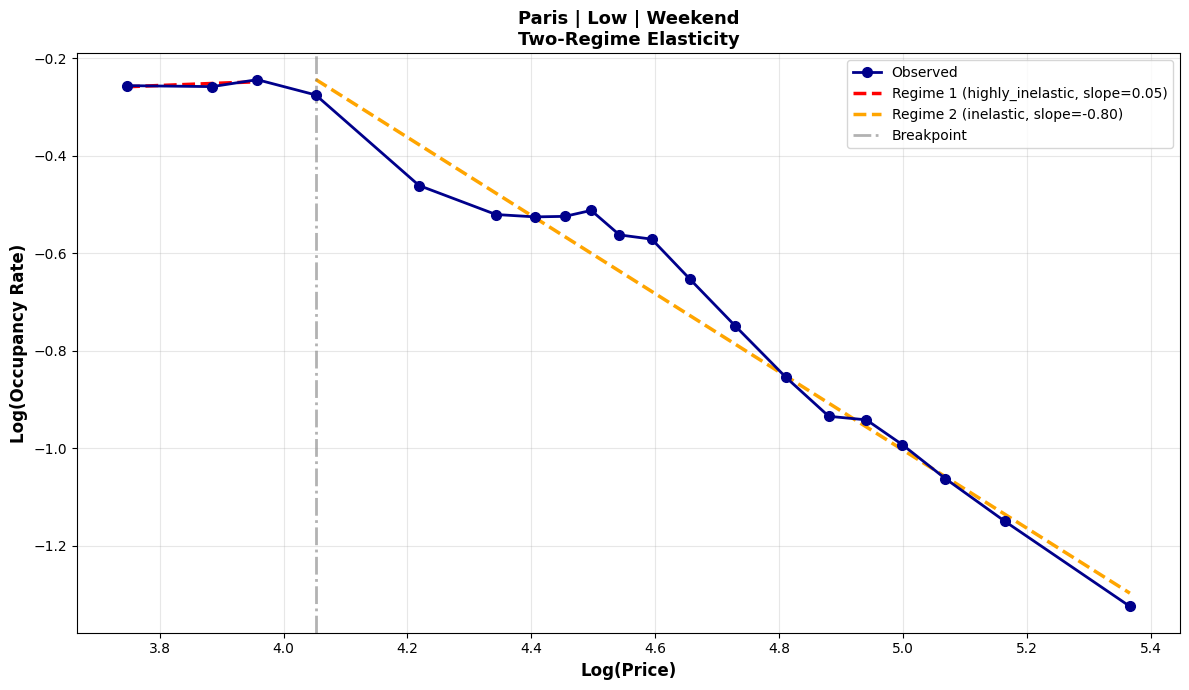


Processing elasticity for city: ROME
Total valid rows for rome: 54,162

  ────────────────────────────────────────────────────────────
  Season: HIGH
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 9,027
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 5/20)
        Regime 1: slope=0.03 (highly_inelastic), R²=0.65
        Regime 2: slope=-0.60 (inelastic), R²=0.96


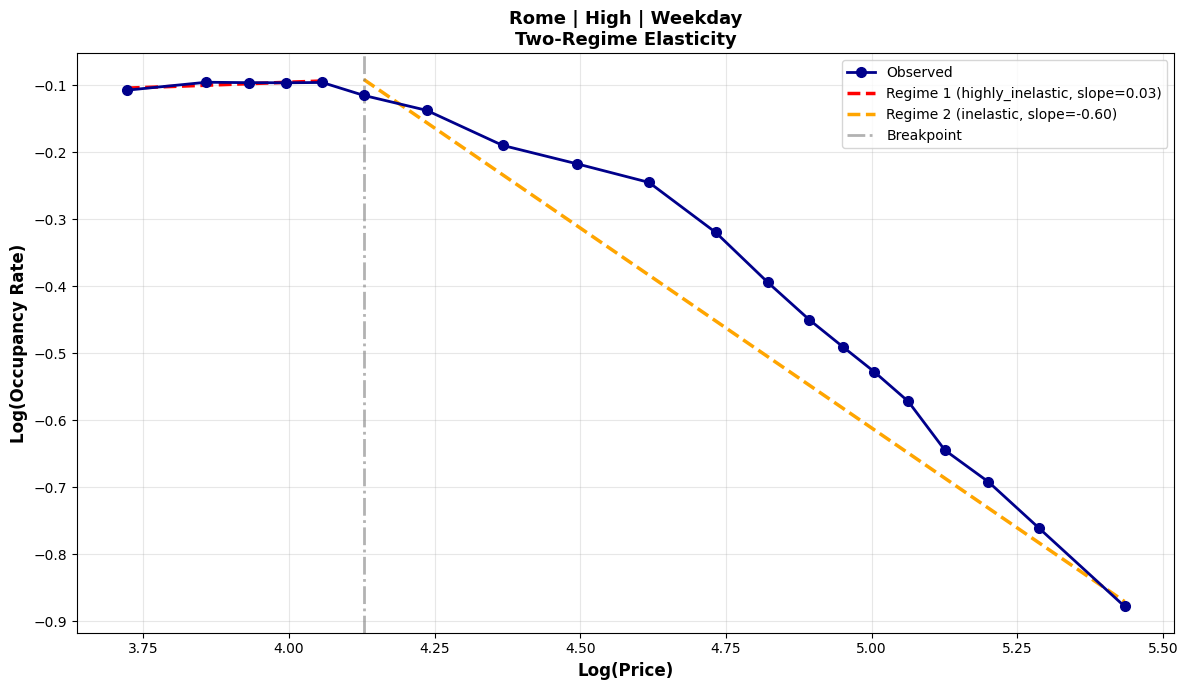


    WEEKEND:
      Rows in segment: 9,027
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 3/20)
        Regime 1: slope=0.14 (highly_inelastic), R²=0.81
        Regime 2: slope=-0.42 (inelastic), R²=0.92


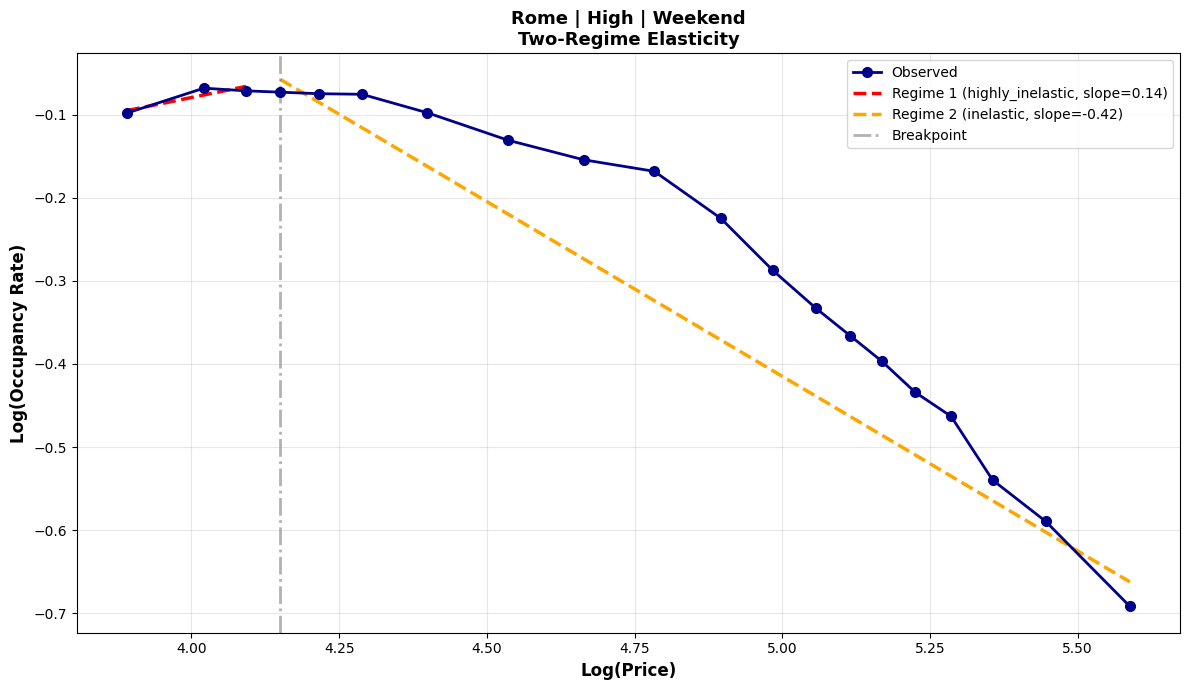


  ────────────────────────────────────────────────────────────
  Season: SHOULDER
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 9,027
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 4/20)
        Regime 1: slope=-0.11 (highly_inelastic), R²=0.74
        Regime 2: slope=-0.77 (inelastic), R²=0.98



    WEEKEND:
      Rows in segment: 9,027
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 6/20)
        Regime 1: slope=-0.06 (highly_inelastic), R²=0.89
        Regime 2: slope=-0.73 (inelastic), R²=0.98


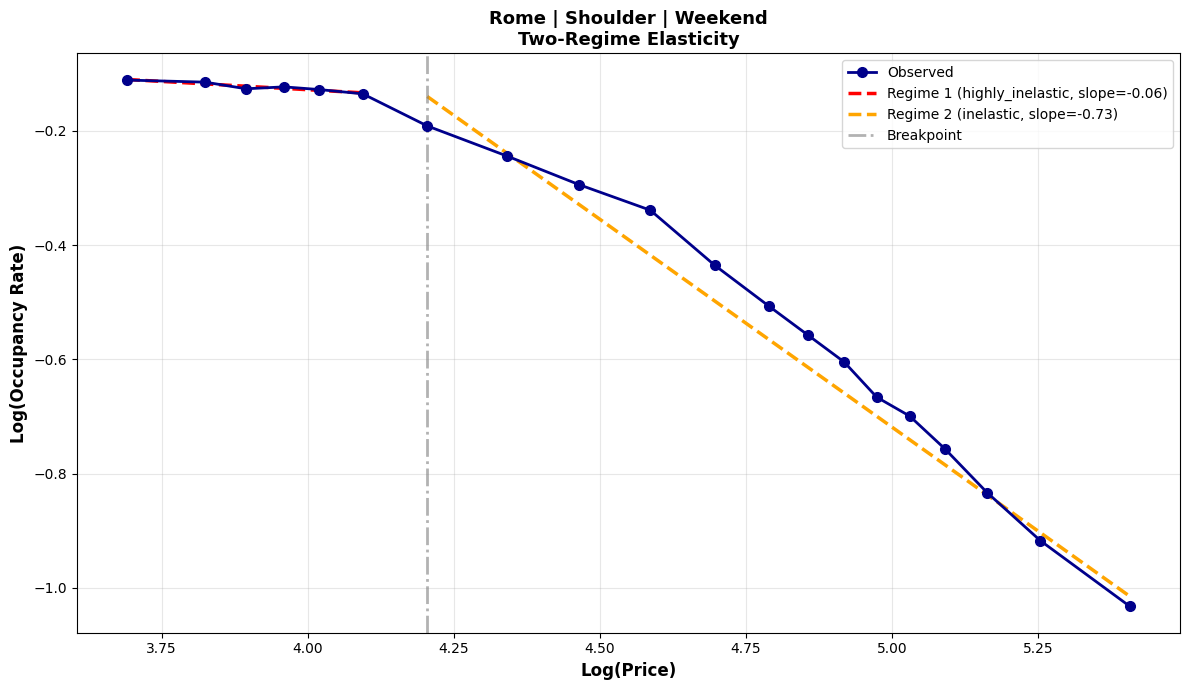


  ────────────────────────────────────────────────────────────
  Season: LOW
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 9,027
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 3/20)
        Regime 1: slope=-0.22 (inelastic), R²=0.98
        Regime 2: slope=-0.86 (inelastic), R²=0.98


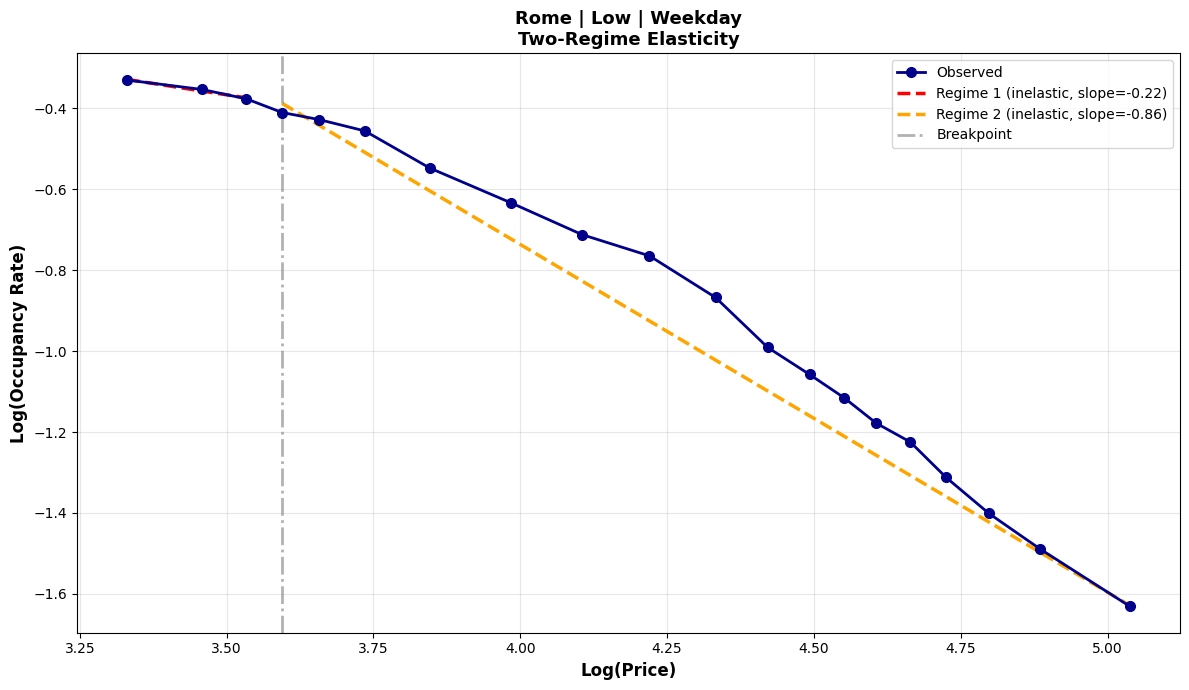


    WEEKEND:
      Rows in segment: 9,027
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 5/20)
        Regime 1: slope=-0.11 (highly_inelastic), R²=0.96
        Regime 2: slope=-0.76 (inelastic), R²=0.98


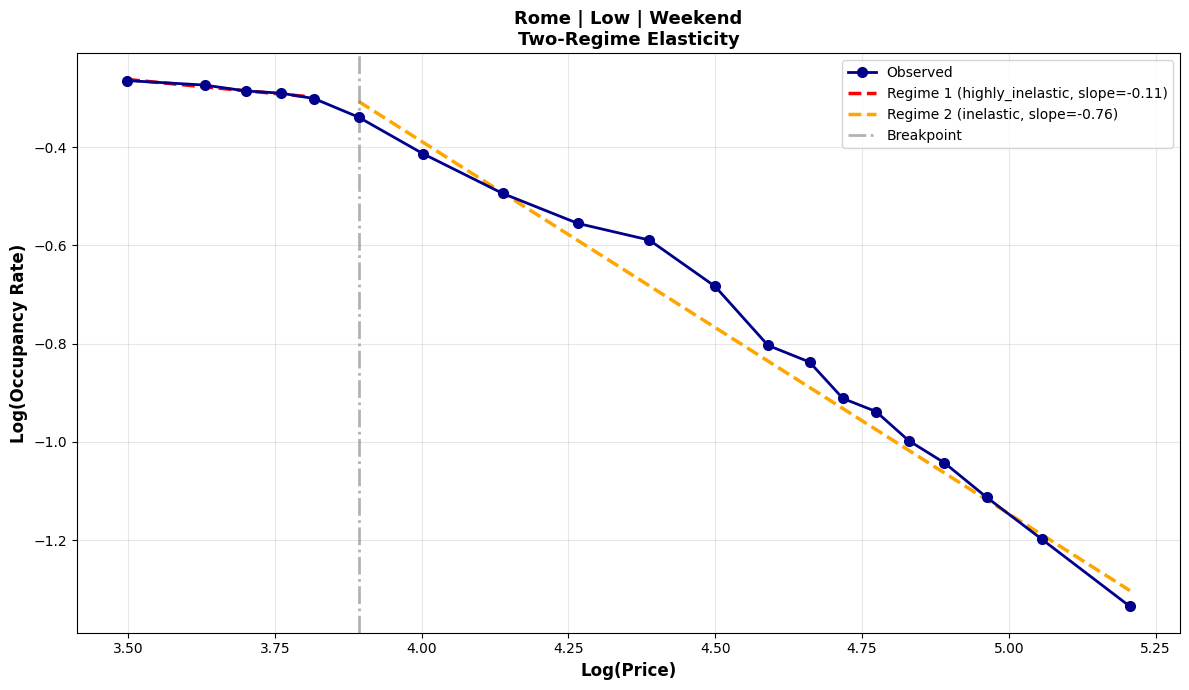


Processing elasticity for city: VIENNA
Total valid rows for vienna: 21,222

  ────────────────────────────────────────────────────────────
  Season: HIGH
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 3,537
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 3/20)
        Regime 1: slope=0.08 (highly_inelastic), R²=0.91
        Regime 2: slope=-0.55 (inelastic), R²=0.92



    WEEKEND:
      Rows in segment: 3,537
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 9/20)
        Regime 1: slope=-0.13 (highly_inelastic), R²=0.83
        Regime 2: slope=-0.65 (inelastic), R²=0.99



  ────────────────────────────────────────────────────────────
  Season: SHOULDER
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 3,537
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 3/20)
        Regime 1: slope=-0.15 (highly_inelastic), R²=0.99
        Regime 2: slope=-0.74 (inelastic), R²=0.96


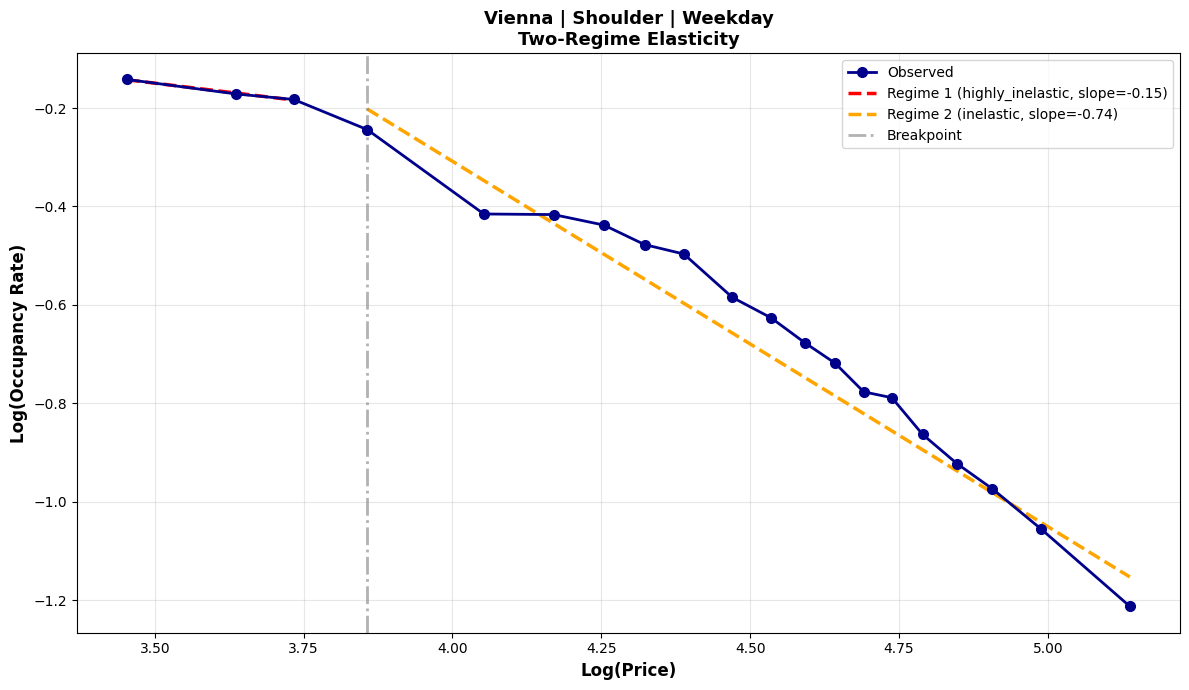


    WEEKEND:
      Rows in segment: 3,537
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 3/20)
        Regime 1: slope=-0.04 (highly_inelastic), R²=0.42
        Regime 2: slope=-0.66 (inelastic), R²=0.95


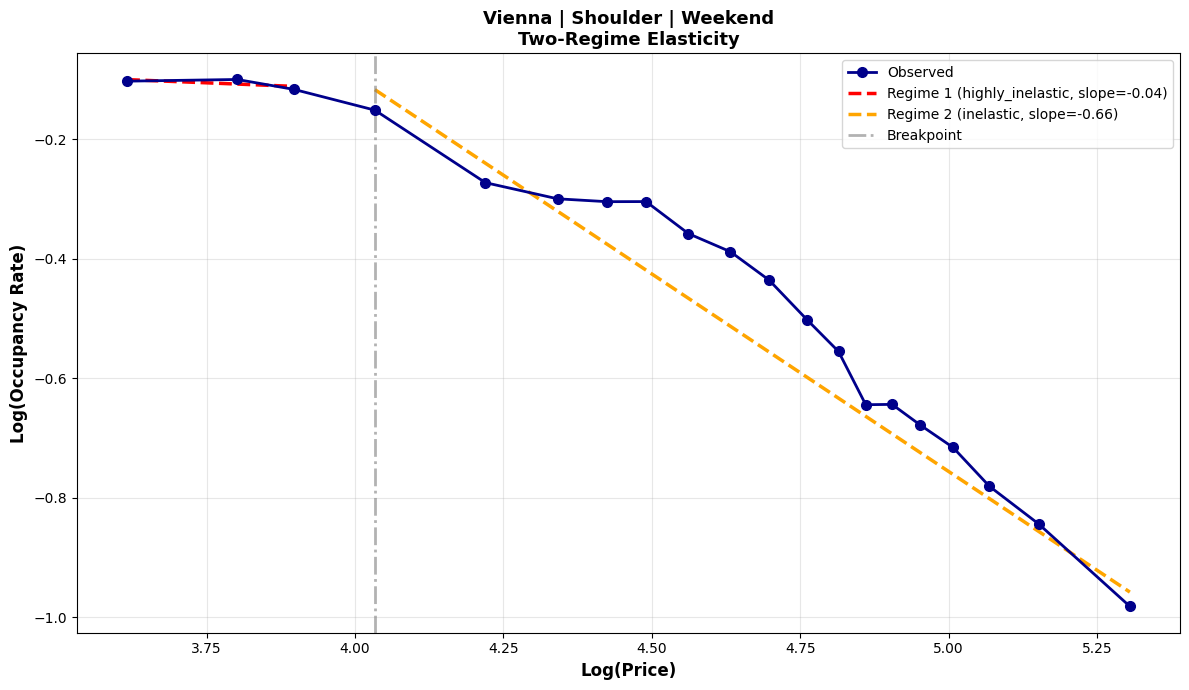


  ────────────────────────────────────────────────────────────
  Season: LOW
  ────────────────────────────────────────────────────────────

    WEEKDAY:
      Rows in segment: 3,537
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 3/20)
        Regime 1: slope=-0.23 (inelastic), R²=1.00
        Regime 2: slope=-0.84 (inelastic), R²=0.96


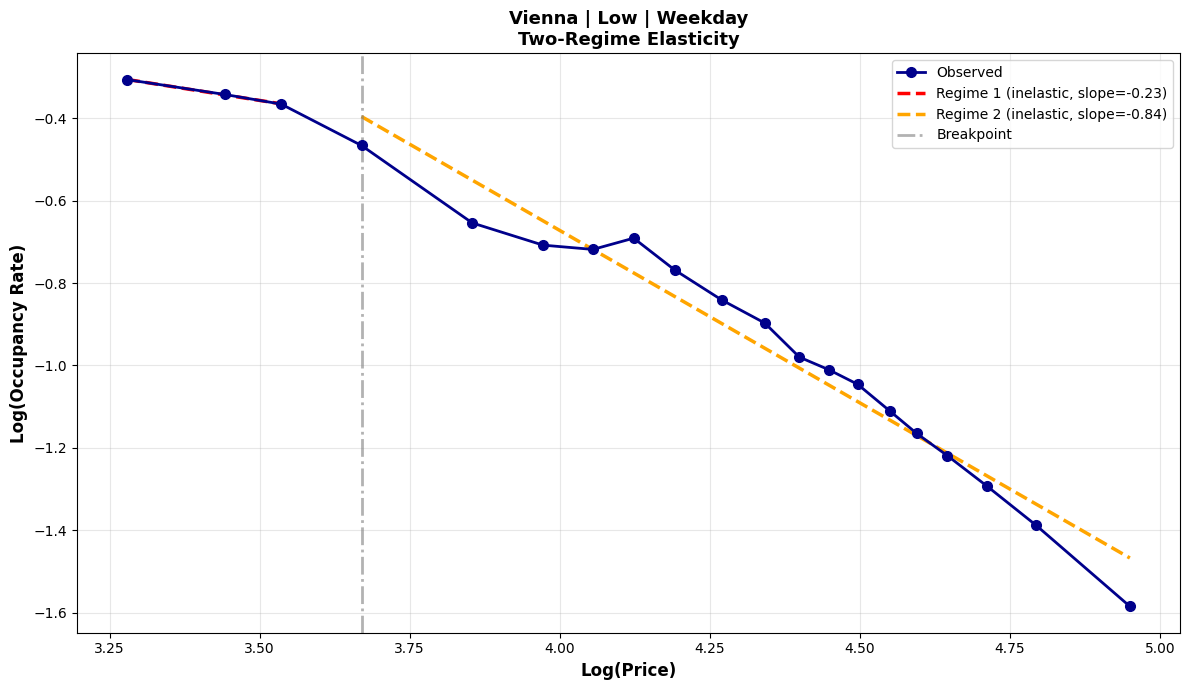


    WEEKEND:
      Rows in segment: 3,537
      Using 20 bins (very large segment)
      Bins created: 20
      Valid bins: 20
      Two-regime fit (breakpoint at bin 9/20)
        Regime 1: slope=-0.46 (inelastic), R²=0.94
        Regime 2: slope=-0.92 (inelastic), R²=0.99



ELASTICITY SUMMARY



Total segments analyzed: 60
Saved to: outputs\elasticities_by_segment.json
Saved to: outputs\elasticity_summary.csv


In [12]:
# ============================================================================
# ELASTICITY ANALYSIS WITH ADAPTIVE BINNING AND PROPER FILTERING
# ============================================================================

from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import json
from pathlib import Path

# Storage for elasticity estimates
elasticities_by_segment = {}

city_list = ['amsterdam', 'athens', 'barcelona', 'berlin', 'budapest', 'lisbon', 'london', 'paris', 'rome', 'vienna']

def classify_elasticity(slope):
    """Classify price elasticity from log-log regression slope"""
    if slope < -1.05:
        return "elastic"
    elif -1.05 <= slope <= -0.95:
        return "unit_elastic"
    elif -0.95 < slope < -0.15:
        return "inelastic"
    elif -0.15 <= slope < 0.15:
        return "highly_inelastic"
    else:
        return "positive"


# ============================================================================
# STEP 1: FILTER INVALID DATA UPFRONT (before any segmentation)
# ============================================================================

print("Filtering invalid data upfront...")
df_valid = df.where(
    (F.col("city").isin(city_list)) &
    (F.col("listing_price").isNotNull()) &
    (F.col("listing_price") > 0) &
    (F.col("occupancy_rate").isNotNull()) &
    (F.col("occupancy_rate") > 0) &  # Zero occupancy breaks log transformation
    (F.col("season").isNotNull()) &
    (F.col("weekend").isNotNull())
)

total_valid = df_valid.count()
print(f"Valid rows after filtering: {total_valid:,}\n")

if total_valid == 0:
    print("ERROR: No valid data found after filtering!")
    print("Check that your df has columns: city, listing_price, occupancy_rate, season, weekend")
else:
    # ============================================================================
    # STEP 2: PROCESS EACH CITY × SEASON × WEEKEND COMBINATION
    # ============================================================================
    
    for city in city_list:
        print(f"\n{'='*70}")
        print(f"Processing elasticity for city: {city.upper()}")
        print('='*70)
        
        # Filter for this city once
        df_city = df_valid.where(F.col("city") == city)
        city_count = df_city.count()
        
        print(f"Total valid rows for {city}: {city_count:,}")
        
        if city_count == 0:
            print(f"No data for {city}, skipping...")
            continue
        
        # Process each season
        for season in ['high', 'shoulder', 'low']:
            print(f"\n  {'─'*60}")
            print(f"  Season: {season.upper()}")
            print(f"  {'─'*60}")
            
            # Process weekday vs weekend
            for weekend_flag in [0, 1]:
                day_type = "weekend" if weekend_flag == 1 else "weekday"
                segment_key = f"{city}_{season}_season_{day_type}"
                
                print(f"\n    {day_type.upper()}:")
                
                # Filter by season AND weekend
                df_segment = df_city.where(
                    (F.col("season") == season) &
                    (F.col("weekend") == weekend_flag)
                )
                
                # Count rows in this segment
                segment_count = df_segment.count()
                print(f"      Rows in segment: {segment_count:,}")
                
                # ============================================================
                # ADAPTIVE BIN COUNT based on data volume
                # ============================================================
                if segment_count < 50:
                    print(f"      Skipping (need ≥50 rows, have {segment_count})")
                    continue
                elif segment_count < 100:
                    n_bins = 5
                    print(f"      Using {n_bins} bins (small segment)")
                elif segment_count < 200:
                    n_bins = 10
                    print(f"      Using {n_bins} bins (medium segment)")
                elif segment_count < 300:
                    n_bins = 15
                    print(f"      Using {n_bins} bins (large segment)")
                else:
                    n_bins = 20
                    print(f"      Using {n_bins} bins (very large segment)")
                
                # Create price bins
                w = Window.orderBy(F.col("listing_price").asc())
                df_binned = df_segment.withColumn("price_bin", F.ntile(n_bins).over(w))
                
                # Aggregate by bin
                price_bins_spark = (
                    df_binned.groupBy("price_bin")
                    .agg(
                        F.count("*").alias("listing_count"),
                        F.mean("listing_price").alias("avg_price"),
                        F.mean("occupancy_rate").alias("avg_occupancy_rate"),
                    )
                    .orderBy("price_bin")
                )
                
                # Collect to pandas
                elasticity_pdf = price_bins_spark.toPandas().sort_values("price_bin")
                
                if len(elasticity_pdf) == 0:
                    print(f"      No bins created")
                    continue
                
                print(f"      Bins created: {len(elasticity_pdf)}")
                
                # Log-log transformation
                elasticity_pdf["log_price"] = np.log(elasticity_pdf["avg_price"])
                elasticity_pdf["log_occupancy_rate"] = np.log(elasticity_pdf["avg_occupancy_rate"])
                
                # Filter out any invalid log values (shouldn't happen with upfront filtering)
                elasticity_valid = elasticity_pdf[
                    (elasticity_pdf["log_price"].notna()) &
                    (elasticity_pdf["log_occupancy_rate"].notna()) &
                    np.isfinite(elasticity_pdf["log_price"]) &
                    np.isfinite(elasticity_pdf["log_occupancy_rate"])
                ].copy().reset_index(drop=True)
                
                if len(elasticity_valid) < 3:
                    print(f"      Insufficient valid bins: {len(elasticity_valid)}")
                    continue
                
                print(f"      Valid bins: {len(elasticity_valid)}")
                
                # ============================================================
                # BREAKPOINT DETECTION
                # ============================================================
                best_breakpoint_idx = None
                best_slope_diff = 0
                best_r2_sum = 0
                
                min_region_size = np.max([2, len(elasticity_valid) // 6])
                
                if len(elasticity_valid) >= 6:  # Only try breakpoints if enough data
                    for breakpoint_idx in range(min_region_size, len(elasticity_valid) - min_region_size):
                        region1 = elasticity_valid.iloc[:breakpoint_idx]
                        region2 = elasticity_valid.iloc[breakpoint_idx:]
                        
                        try:
                            slope1, intercept1, r1, _, _ = stats.linregress(region1["log_price"], region1["log_occupancy_rate"])
                            slope2, intercept2, r2, _, _ = stats.linregress(region2["log_price"], region2["log_occupancy_rate"])
                        except:
                            continue
                        
                        slope_diff = abs(slope2 - slope1)
                        r2_sum = r1**2 + r2**2
                        score = slope_diff * 100 + r2_sum
                        
                        if score > (best_slope_diff * 100 + best_r2_sum):
                            best_breakpoint_idx = breakpoint_idx
                            best_slope_diff = slope_diff
                            best_r2_sum = r2_sum
                
                # ============================================================
                # FIT ELASTICITY MODEL (single or dual regime)
                # ============================================================
                use_two_regimes = best_slope_diff > 0.3 and len(elasticity_valid) >= 6
                
                if use_two_regimes and best_breakpoint_idx is not None:
                    # Two-regime model
                    region1 = elasticity_valid.iloc[:best_breakpoint_idx]
                    region2 = elasticity_valid.iloc[best_breakpoint_idx:]
                    
                    slope1, intercept1, r1, _, _ = stats.linregress(region1["log_price"], region1["log_occupancy_rate"])
                    slope2, intercept2, r2, _, _ = stats.linregress(region2["log_price"], region2["log_occupancy_rate"])
                    
                    breakpoint_price = elasticity_valid.iloc[best_breakpoint_idx]["log_price"]
                    y_at_breakpoint = slope1 * breakpoint_price + intercept1
                    intercept2_adjusted = y_at_breakpoint - slope2 * breakpoint_price
                    
                    regime1_type = classify_elasticity(slope1)
                    regime2_type = classify_elasticity(slope2)
                    
                    print(f"      Two-regime fit (breakpoint at bin {best_breakpoint_idx}/{len(elasticity_valid)})")
                    print(f"        Regime 1: slope={slope1:.2f} ({regime1_type}), R²={r1**2:.2f}")
                    print(f"        Regime 2: slope={slope2:.2f} ({regime2_type}), R²={r2**2:.2f}")
                    
                    elasticities_by_segment[segment_key] = {
                        "n_bins": n_bins,
                        "regimes": [
                            {
                                "name": regime1_type,
                                "slope": float(slope1),
                                "r_squared": float(r1**2),
                                "price_range": "lower",
                                "n_points": len(region1)
                            },
                            {
                                "name": regime2_type,
                                "slope": float(slope2),
                                "r_squared": float(r2**2),
                                "price_range": "upper",
                                "n_points": len(region2)
                            }
                        ],
                        "breakpoint_log_price": float(breakpoint_price),
                        "breakpoint_price_approx": float(np.exp(breakpoint_price))
                    }
                    
                    # Plot two-regime
                    fig, ax = plt.subplots(figsize=(12, 7))
                    ax.plot(elasticity_valid["log_price"], elasticity_valid["log_occupancy_rate"], 
                           marker="o", linewidth=2, markersize=7, color="darkblue", label="Observed", zorder=3)
                    
                    x1 = np.array(region1["log_price"])
                    y1_fit = slope1 * x1 + intercept1
                    ax.plot(x1, y1_fit, linewidth=2.5, linestyle="--", color="red", 
                           label=f"Regime 1 ({regime1_type}, slope={slope1:.2f})", zorder=2)
                    
                    x2 = np.array(region2["log_price"])
                    y2_fit = slope2 * x2 + intercept2_adjusted
                    ax.plot(x2, y2_fit, linewidth=2.5, linestyle="--", color="orange", 
                           label=f"Regime 2 ({regime2_type}, slope={slope2:.2f})", zorder=2)
                    
                    ax.axvline(breakpoint_price, color="gray", linestyle="-.", alpha=0.6, linewidth=2, label="Breakpoint")
                    ax.set_xlabel("Log(Price)", fontsize=12, fontweight="bold")
                    ax.set_ylabel("Log(Occupancy Rate)", fontsize=12, fontweight="bold")
                    ax.set_title(f"{city.capitalize()} | {season.capitalize()} | {day_type.capitalize()}\nTwo-Regime Elasticity", 
                                fontsize=13, fontweight="bold")
                    ax.grid(True, alpha=0.3)
                    ax.legend(loc="best", fontsize=10)
                    plt.tight_layout()
                    plt.savefig(output_dir / f"elasticity_{city}_{season}_{day_type}_2regime.png", dpi=150)
                    plt.show()
                    plt.close()
                    
                else:
                    # Single-regime model
                    slope_full, intercept_full, r_value_full, _, _ = stats.linregress(
                        elasticity_valid["log_price"], 
                        elasticity_valid["log_occupancy_rate"]
                    )
                    
                    regime_type = classify_elasticity(slope_full)
                    print(f"      Single-regime: slope={slope_full:.2f} ({regime_type}), R²={r_value_full**2:.2f}")
                    
                    elasticities_by_segment[segment_key] = {
                        "n_bins": n_bins,
                        "regimes": [
                            {
                                "name": regime_type,
                                "slope": float(slope_full),
                                "r_squared": float(r_value_full**2),
                                "price_range": "full",
                                "n_points": len(elasticity_valid)
                            }
                        ]
                    }
                    
                    # Plot single-regime
                    fig, ax = plt.subplots(figsize=(12, 7))
                    ax.plot(elasticity_valid["log_price"], elasticity_valid["log_occupancy_rate"], 
                           marker="o", linewidth=2, markersize=7, color="darkblue", label="Observed", zorder=3)
                    
                    x_full = np.array(elasticity_valid["log_price"])
                    y_full_fit = slope_full * x_full + intercept_full
                    ax.plot(x_full, y_full_fit, linewidth=2.5, linestyle="--", color="red", 
                           label=f"{regime_type.upper()} (slope={slope_full:.2f}, R²={r_value_full**2:.2f})", zorder=2)
                    
                    ax.set_xlabel("Log(Price)", fontsize=12, fontweight="bold")
                    ax.set_ylabel("Log(Occupancy Rate)", fontsize=12, fontweight="bold")
                    ax.set_title(f"{city.capitalize()} | {season.capitalize()} | {day_type.capitalize()}\nSingle-Regime Elasticity", 
                                fontsize=13, fontweight="bold")
                    ax.grid(True, alpha=0.3)
                    ax.legend(loc="best", fontsize=10)
                    plt.tight_layout()
                    plt.savefig(output_dir / f"elasticity_{city}_{season}_{day_type}_1regime.png", dpi=150)
                    plt.show()
                    plt.close()


# ============================================================================
# SAVE RESULTS
# ============================================================================

print(f"\n{'='*70}")
print("ELASTICITY SUMMARY")
print('='*70)

if len(elasticities_by_segment) > 0:
    # Create summary table
    elasticity_summary = []
    for segment_key, data in elasticities_by_segment.items():
        for i, regime in enumerate(data["regimes"], 1):
            elasticity_summary.append({
                "segment": segment_key,
                "regime": i,
                "regime_type": regime["name"],
                "slope": regime["slope"],
                "r_squared": regime["r_squared"],
                "n_bins": regime["n_points"],
                "price_range": regime["price_range"]
            })
    
    elasticity_summary_df = pd.DataFrame(elasticity_summary)
    
    fmt = {"slope": "{:.2f}", "r_squared": "{:.2f}"}
    display(elasticity_summary_df.style.format(fmt))
    
    # Save to JSON
    elasticity_json_path = output_dir / "elasticities_by_segment.json"
    with open(elasticity_json_path, "w") as f:
        json.dump(elasticities_by_segment, f, indent=2)
    
    # Save to CSV
    elasticity_csv_path = output_dir / "elasticity_summary.csv"
    elasticity_summary_df.to_csv(elasticity_csv_path, index=False)
    
    print(f"\nTotal segments analyzed: {len(elasticities_by_segment)}")
    print(f"Saved to: outputs\elasticities_by_segment.json")
    print(f"Saved to: outputs\elasticity_summary.csv")
else:
    print("\nNo elasticity curves generated. Check the diagnostic output above.")


In [13]:
# Summary Statistics by Segment (Spark groupBy + robust metrics + export)

from pyspark.sql import functions as F
import pandas as pd

# Create day_type column from weekend flag
df_with_day_type = df.withColumn("day_type", F.when(F.col("weekend") == 1, "weekend").otherwise("weekday"))

summary_spark = (
    df_with_day_type.groupBy("city", "day_type")
      .agg(
          F.count("*").alias("n"),
          F.mean("listing_price").alias("avg_price"),
          F.expr("percentile_approx(listing_price, 0.5)").alias("median_price"),
          F.stddev("listing_price").alias("price_std"),
          F.expr("percentile_approx(listing_price, 0.1)").alias("p10_price"),
          F.expr("percentile_approx(listing_price, 0.9)").alias("p90_price"),
          F.mean("guest_satisfaction_overall").alias("avg_satisfaction"),
          F.mean("cleanliness_rating").alias("avg_cleanliness"),
          F.mean("city_center_dist").alias("avg_distance"),
          F.mean("metro_dist").alias("avg_metro_distance"),
          F.mean("person_capacity").alias("avg_capacity"),
          F.mean(F.col("host_is_superhost").cast("double")).alias("superhost_rate"),
      )
      .orderBy("city", "day_type")
)

# Pretty-print Spark aggregate via a styled Pandas DataFrame (safe limit + formatting)
summary_pdf = summary_spark.limit(5000).toPandas().sort_values(["city", "day_type"])
summary_pdf["n"] = summary_pdf["n"].astype(int)

# Format dictionary for display
fmt_summary = {
    "n": "{:,}",
    "avg_price": "{:,.1f}",
    "median_price": "{:,.1f}",
    "price_std": "{:,.1f}",
    "p10_price": "{:,.1f}",
    "p90_price": "{:,.1f}",
    "avg_satisfaction": "{:.1f}",
    "avg_cleanliness": "{:.1f}",
    "avg_distance": "{:,.1f}",
    "avg_metro_distance": "{:,.1f}",
    "avg_capacity": "{:.1f}",
    "superhost_rate": "{:.1%}",
}

display(
    summary_pdf.style.format(fmt_summary)
                       .set_table_attributes("style='width:90%; font-family: Arial; font-size:12px;'")
                       .set_caption("Summary statistics by city x day_type (Spark → Pandas)")
)

# Save outputs
output_dir = project_root / "outputs"
output_dir.mkdir(parents=True, exist_ok=True)

# 1) CSV via Pandas (single file  with sample limit)
summary_pdf.to_csv(output_dir / "summary_statistics_by_segment_limit_5000.csv", index=False)

# 2) CSV via Spark (folder output, scalable)
(
    summary_spark.coalesce(1)
    .write.mode("overwrite")
    .option("header", "true")
    .csv(str(output_dir / "summary_statistics_by_segment_spark"))
)

print(f"Saved:\n- {'outputs/summary_statistics_by_segment_limit_5000.csv'}\n- {'outputs/summary_statistics_by_segment_spark'}")

Saved:
- outputs/summary_statistics_by_segment_limit_5000.csv
- outputs/summary_statistics_by_segment_spark
